# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [41]:
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_feat_no_nans.csv')
product_sales = pd.read_csv('aggregate_products.csv')
pivot_table = pd.read_csv('pivot_products.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [42]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=3, min_dist=0.01)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)


In [43]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Visualize the distribution of departments along lower dimentional embedding

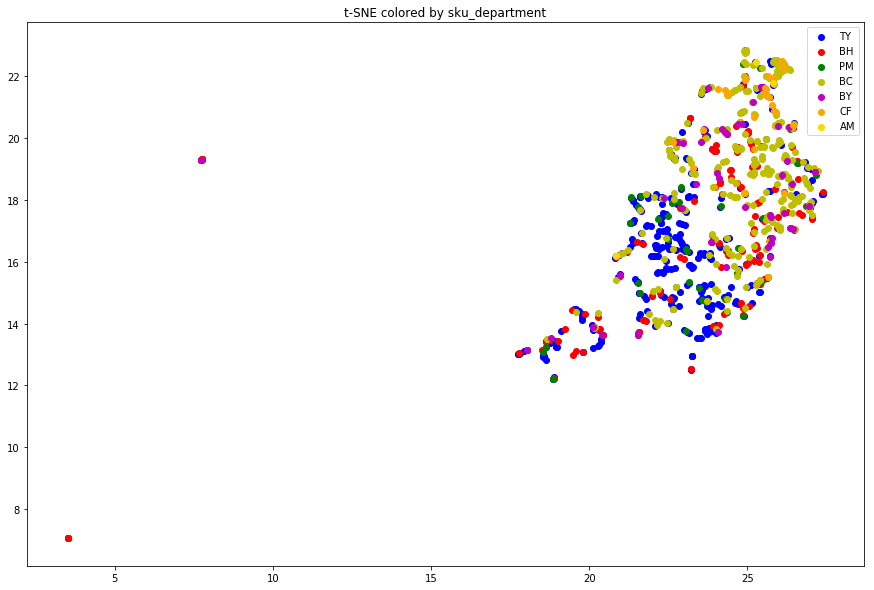

In [44]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

Show distribution of cumulative sales on embedding

In [45]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

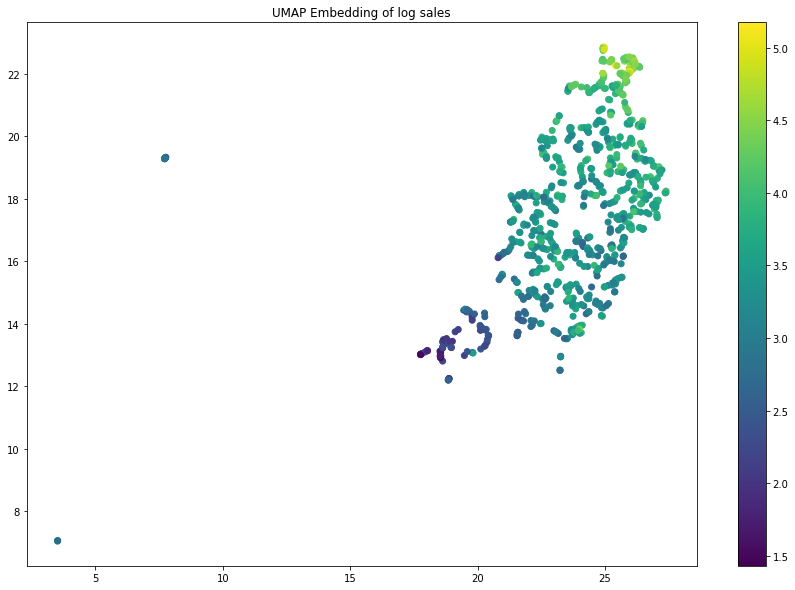

In [46]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [4]:
run_cont = ['sales', 'selling_price', 'avg_discount', 'stock_open']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']

In [22]:
som_clus = pd.read_csv('som_clusters_no_nans.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [23]:
for i, j in df_dict.items():
    print(i, len(j['sku_key'].unique()))

cluster_1 76
cluster_4 504
cluster_0 277
cluster_2 4
cluster_5 6
cluster_3 6


Clusters on embedding

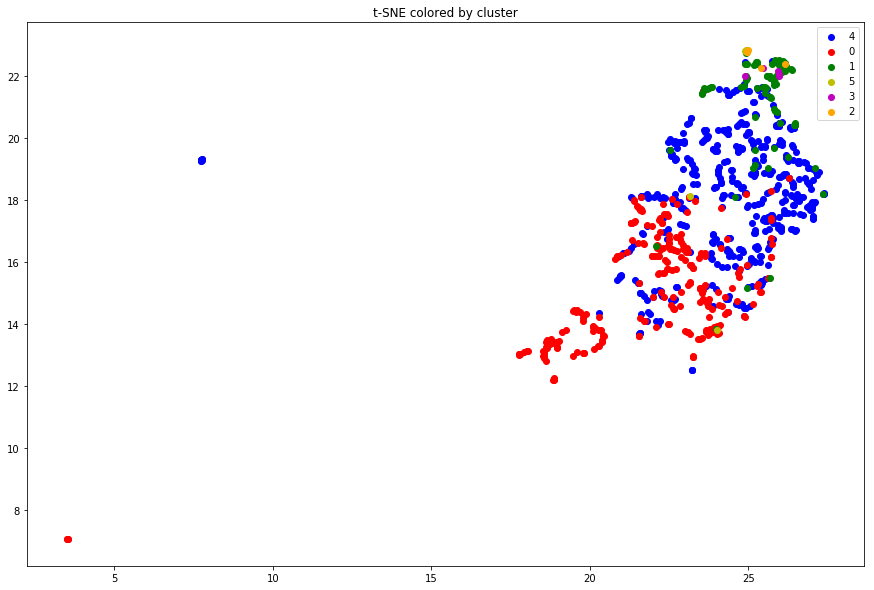

In [47]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

Have a look at the time series for each of the clusters

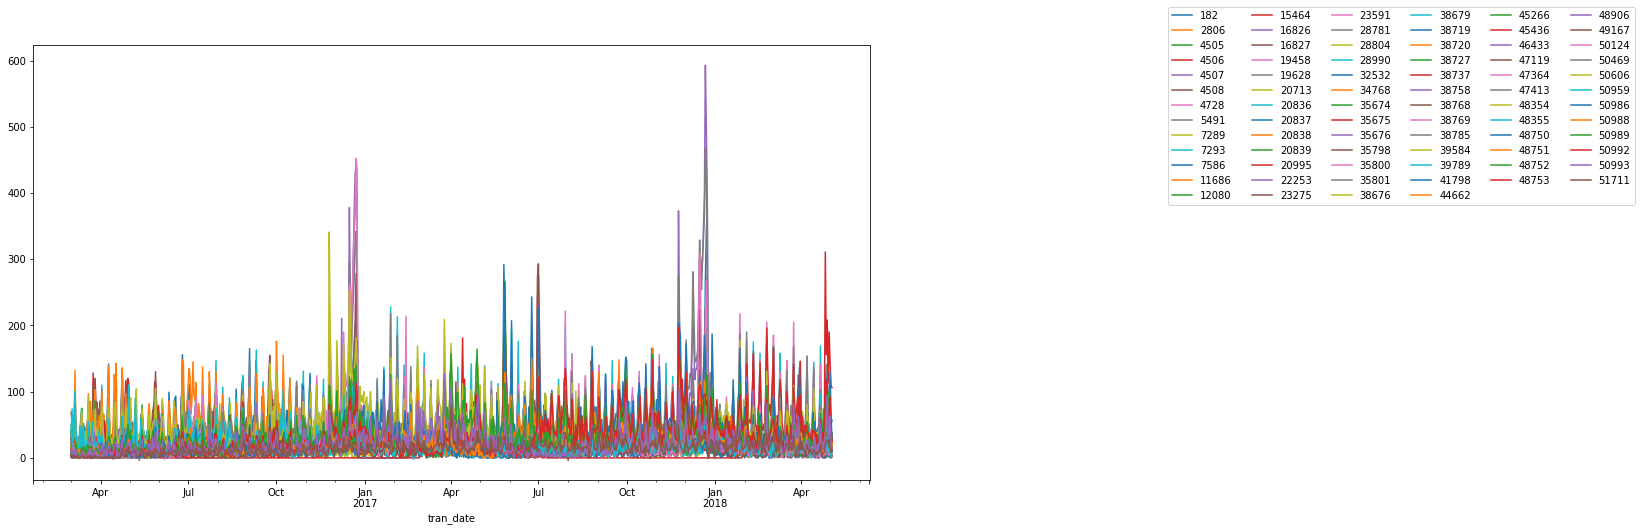

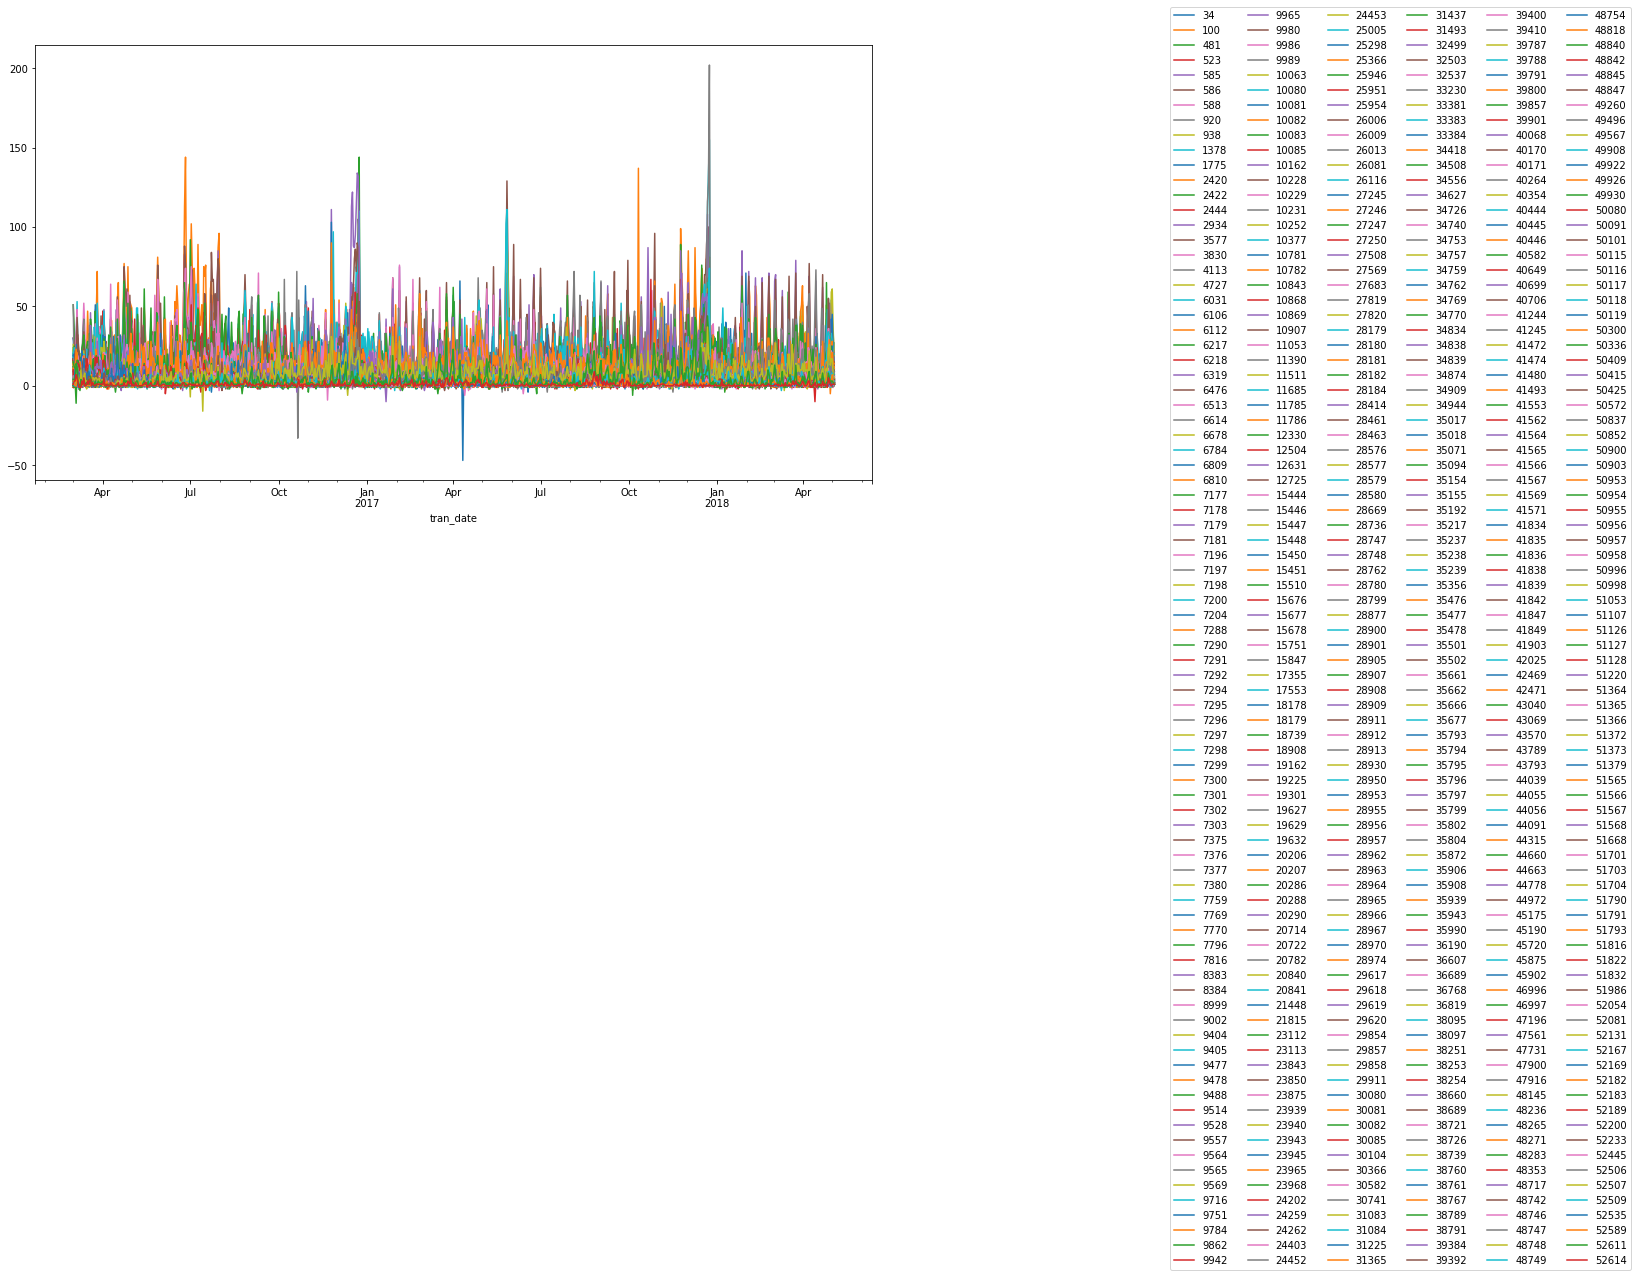

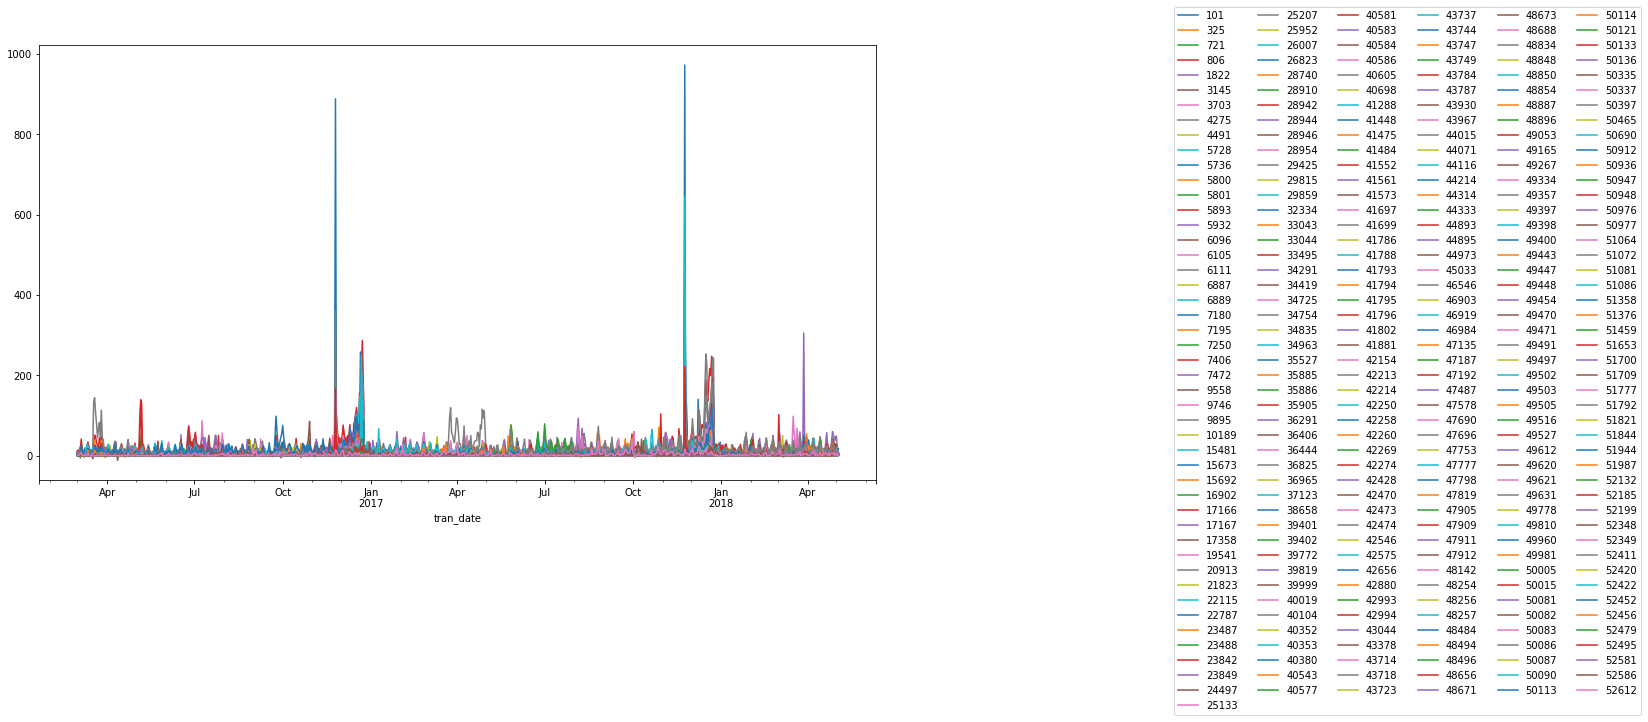

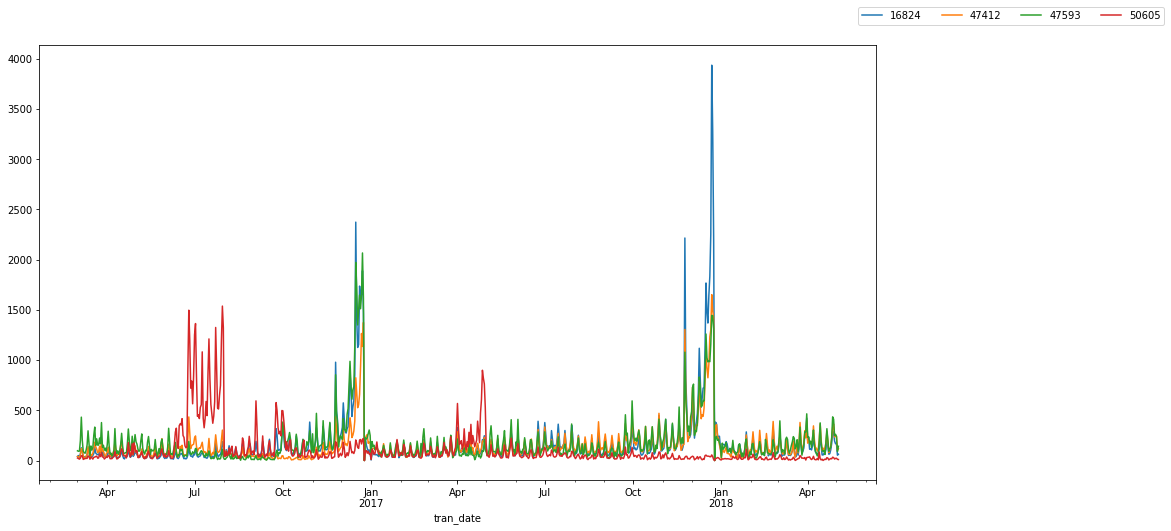

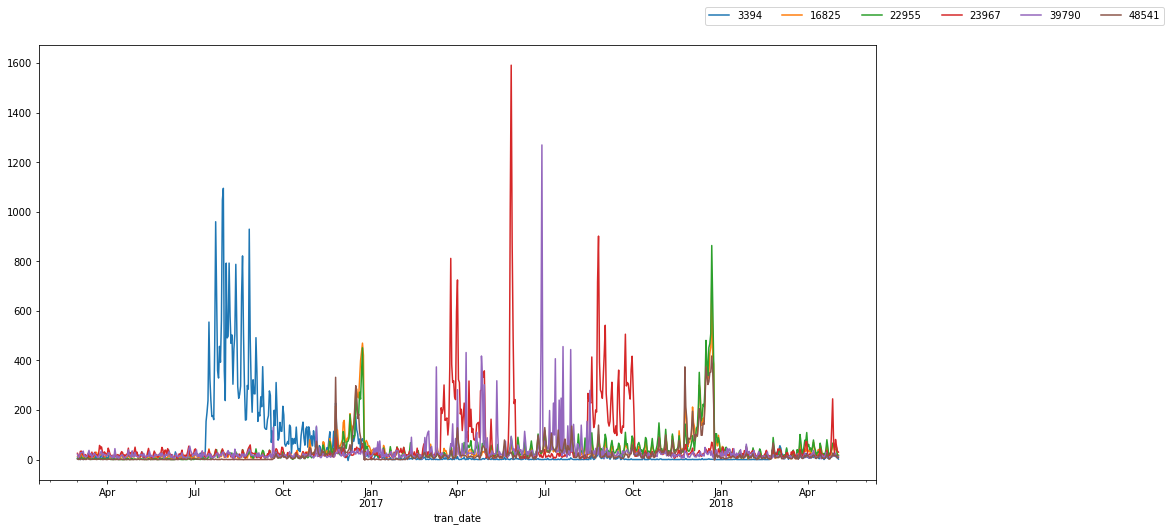

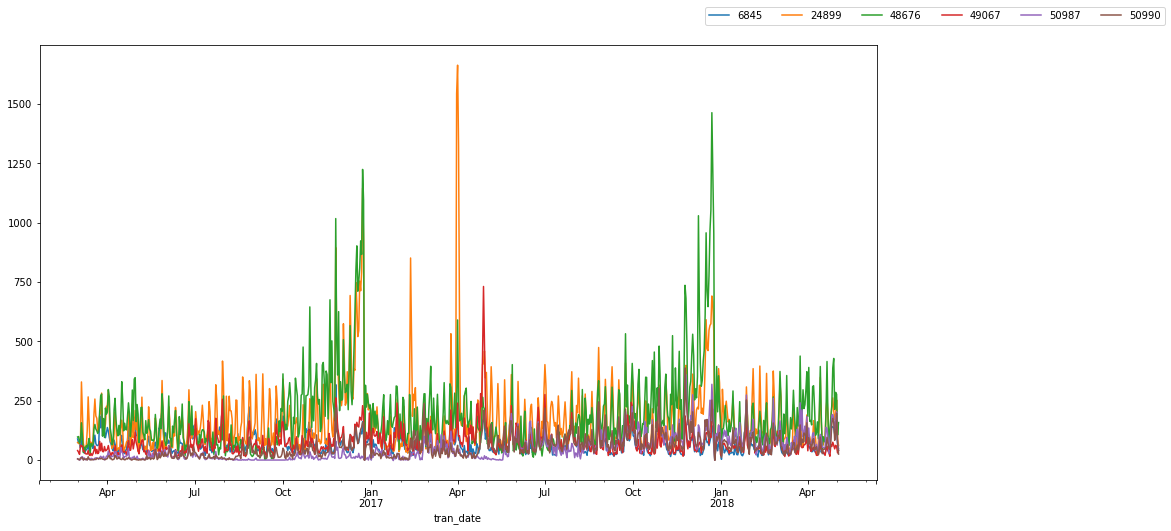

In [26]:
analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

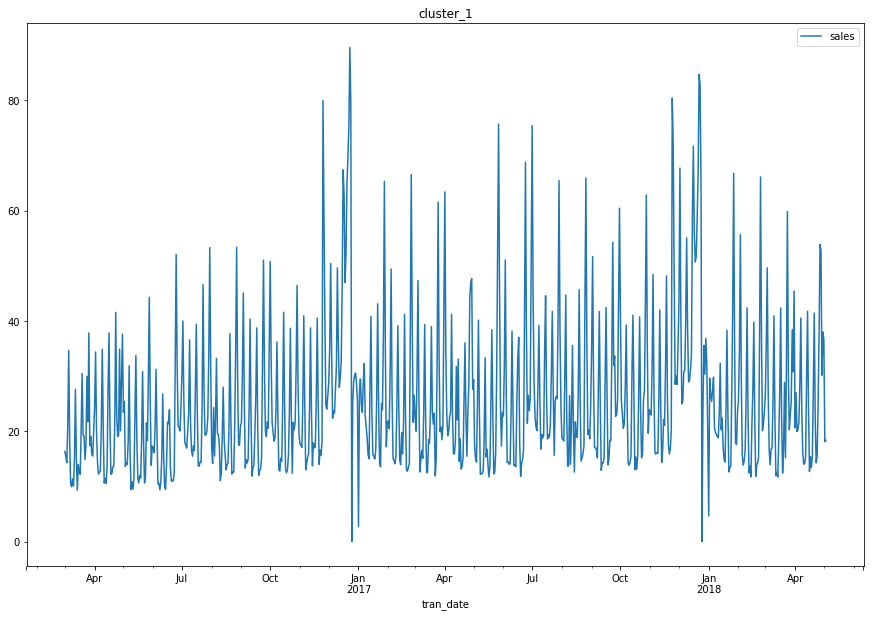

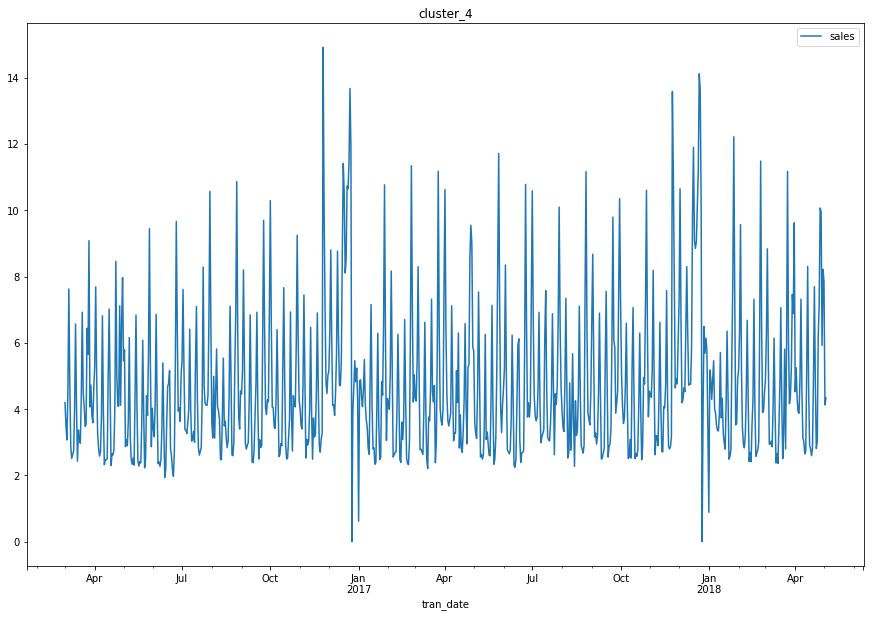

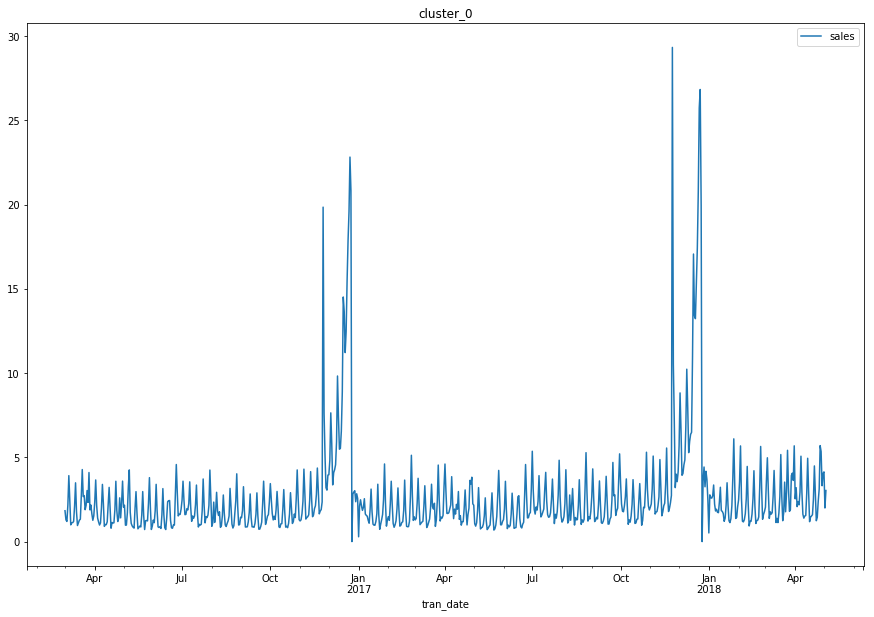

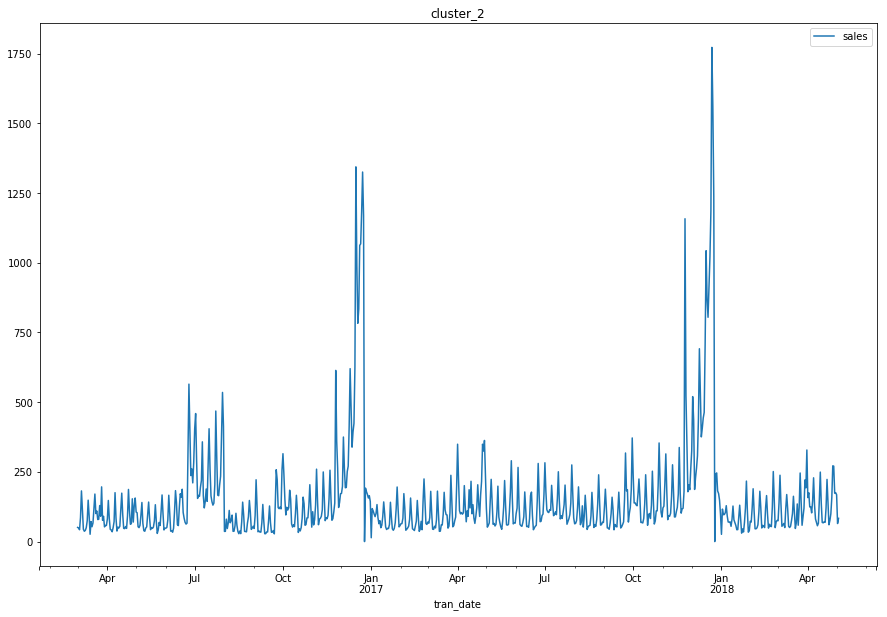

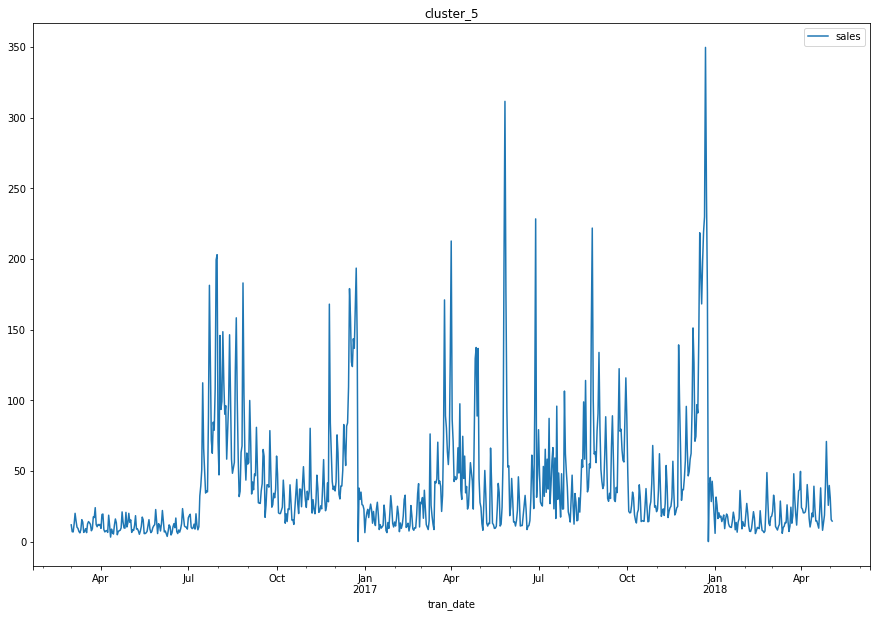

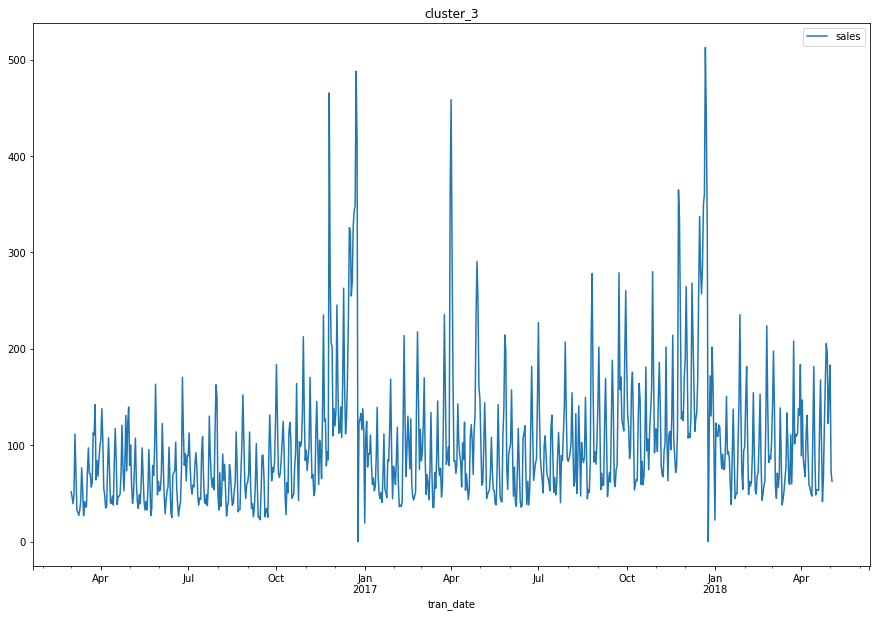

In [27]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

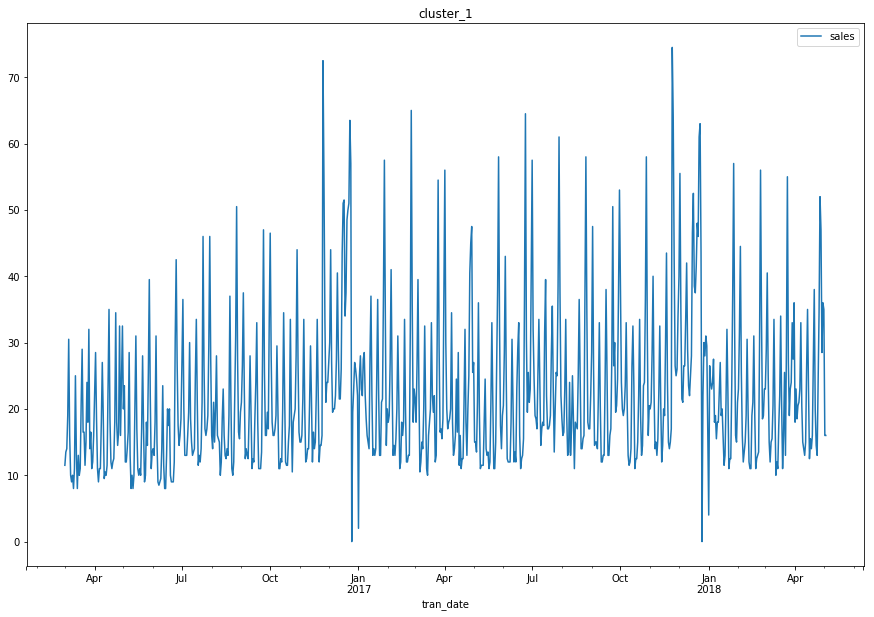

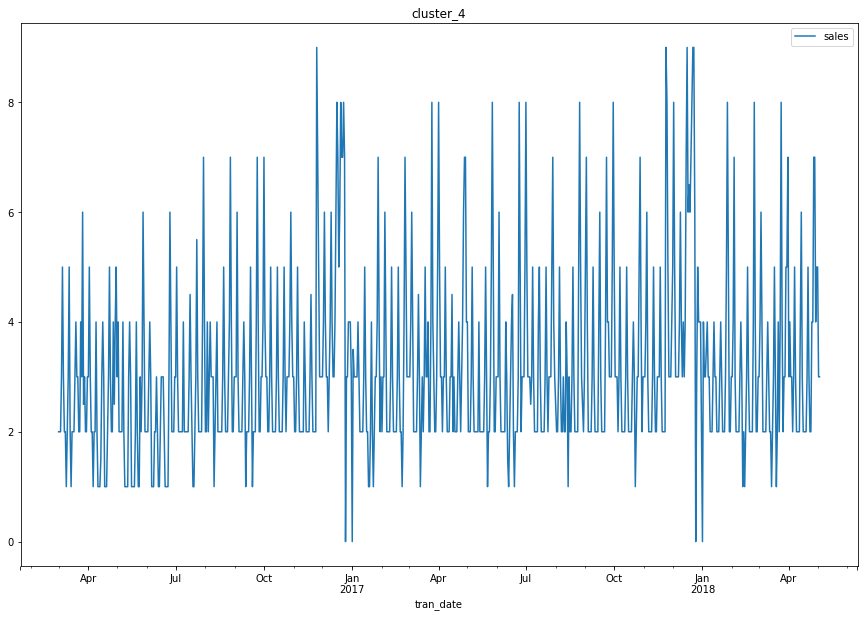

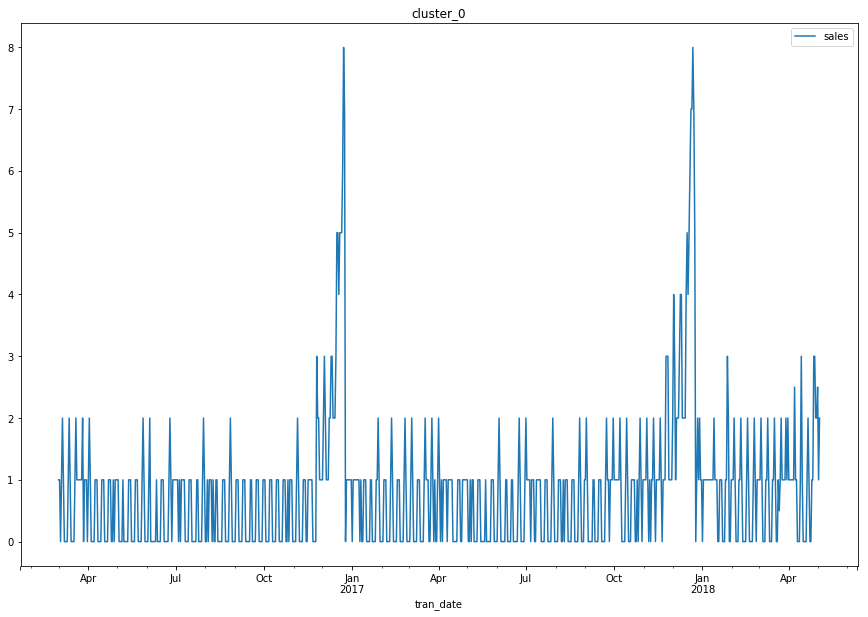

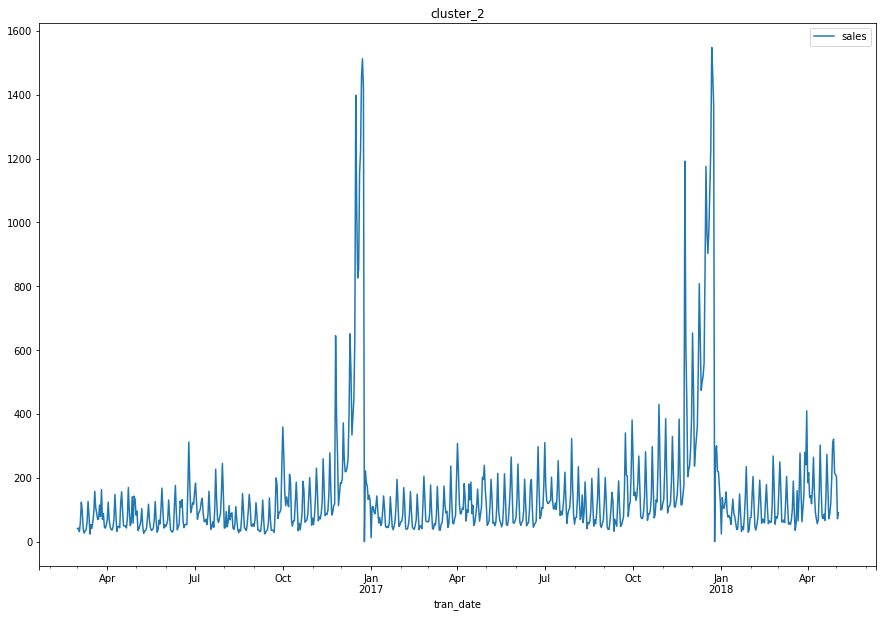

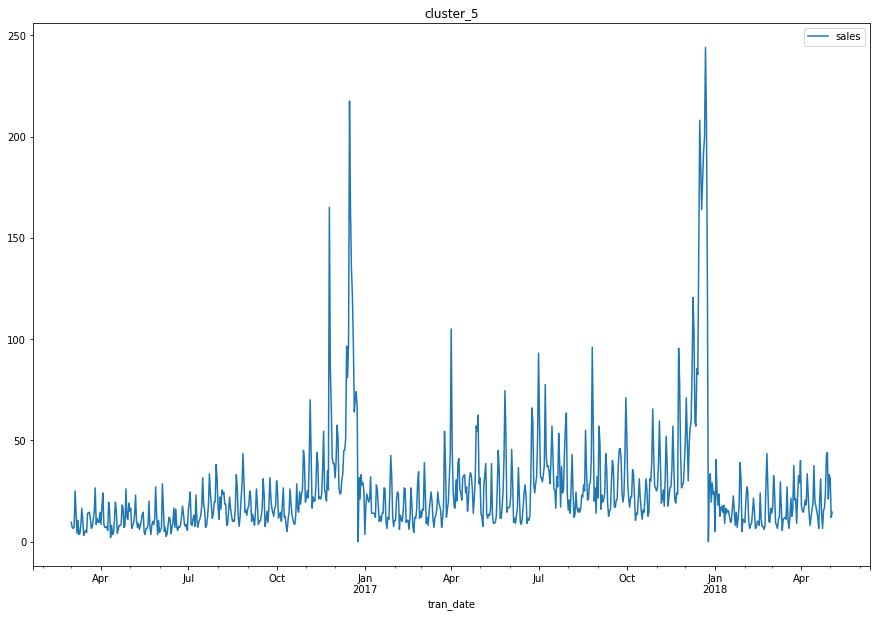

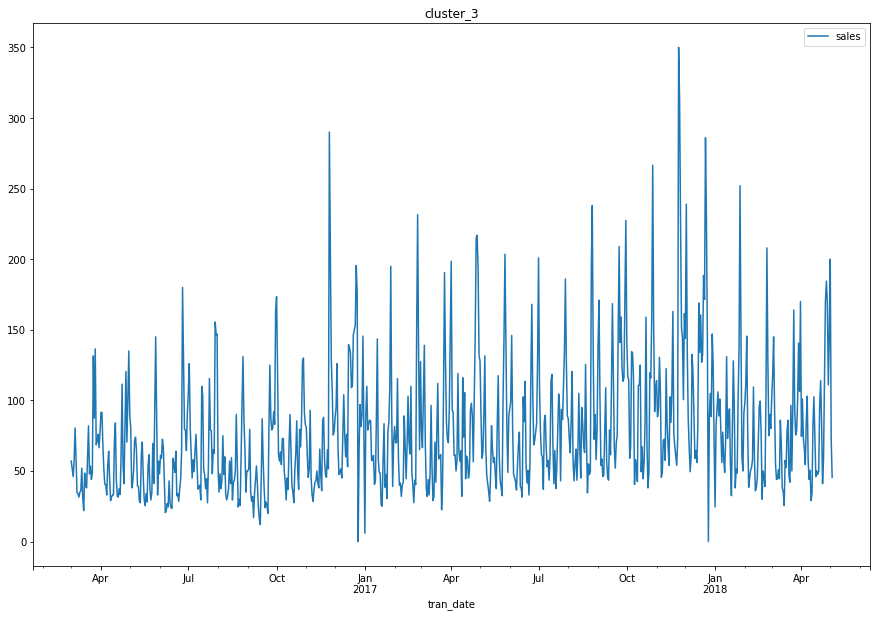

In [28]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

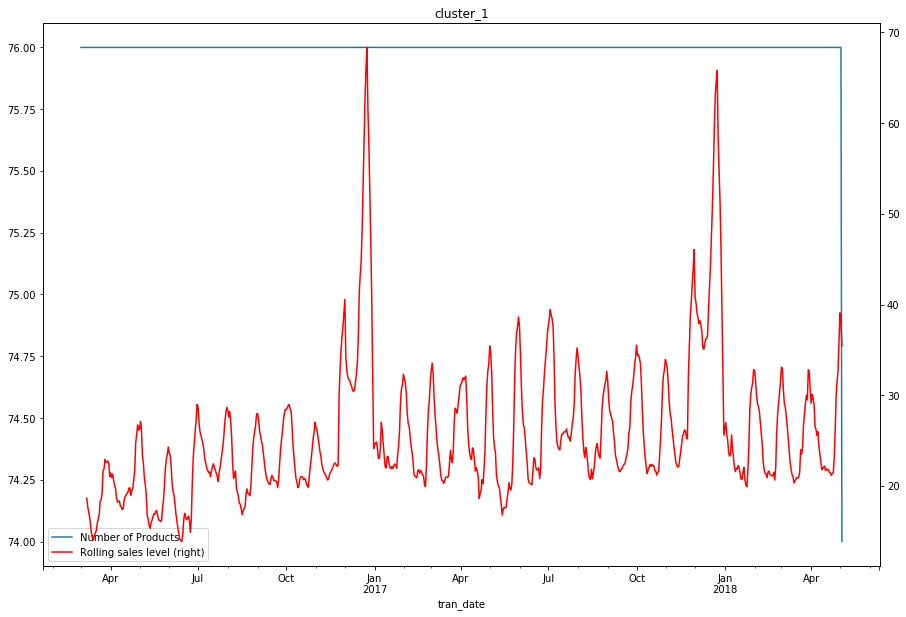

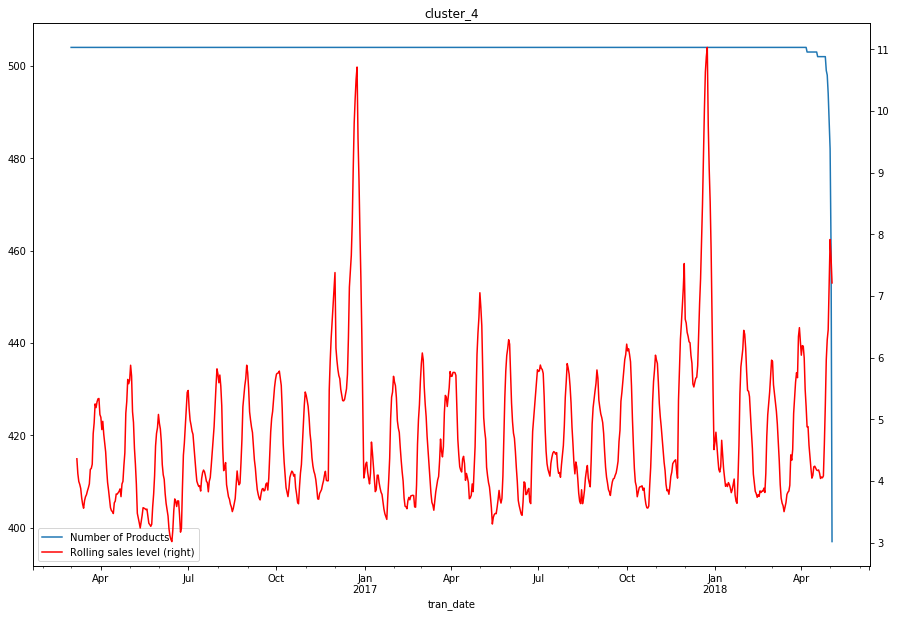

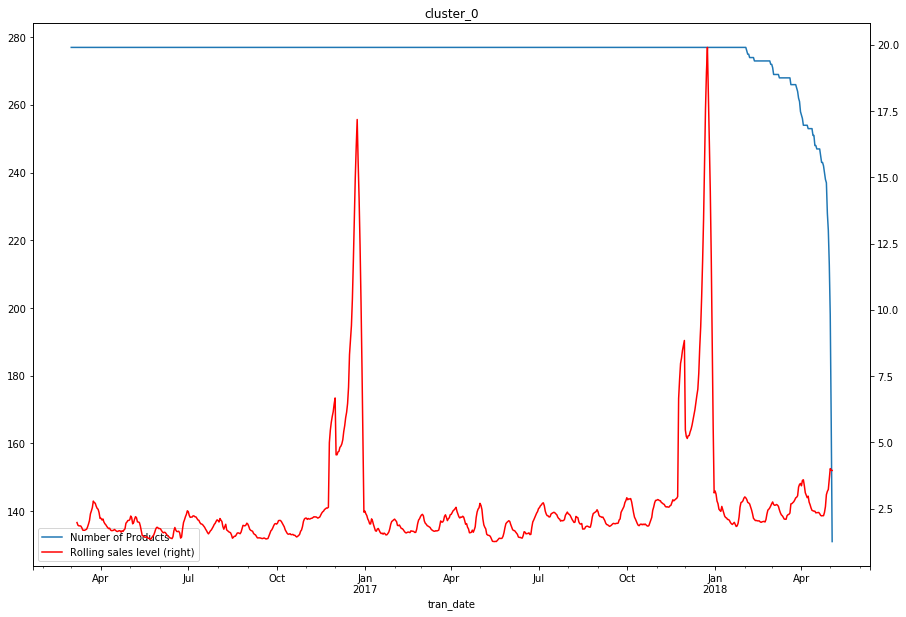

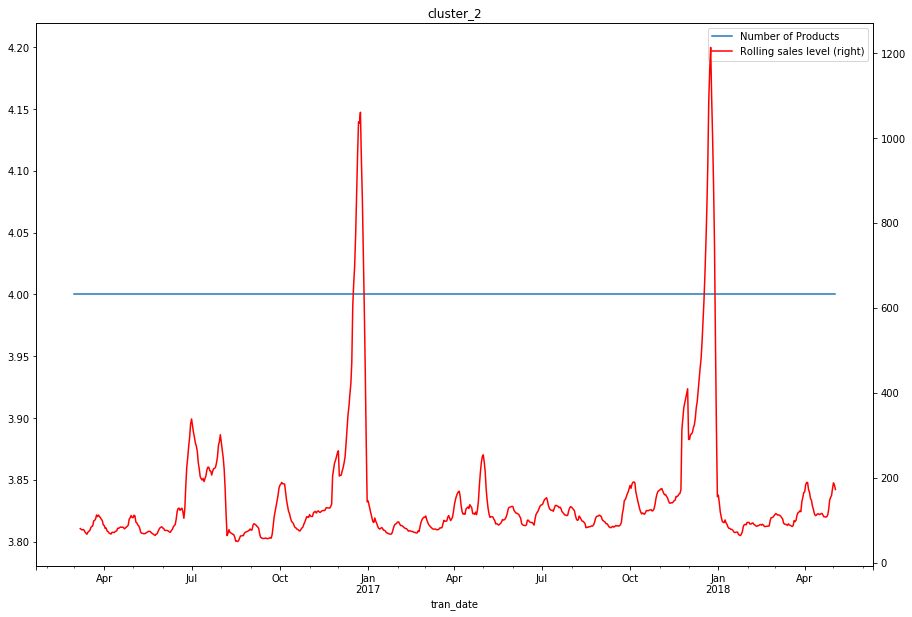

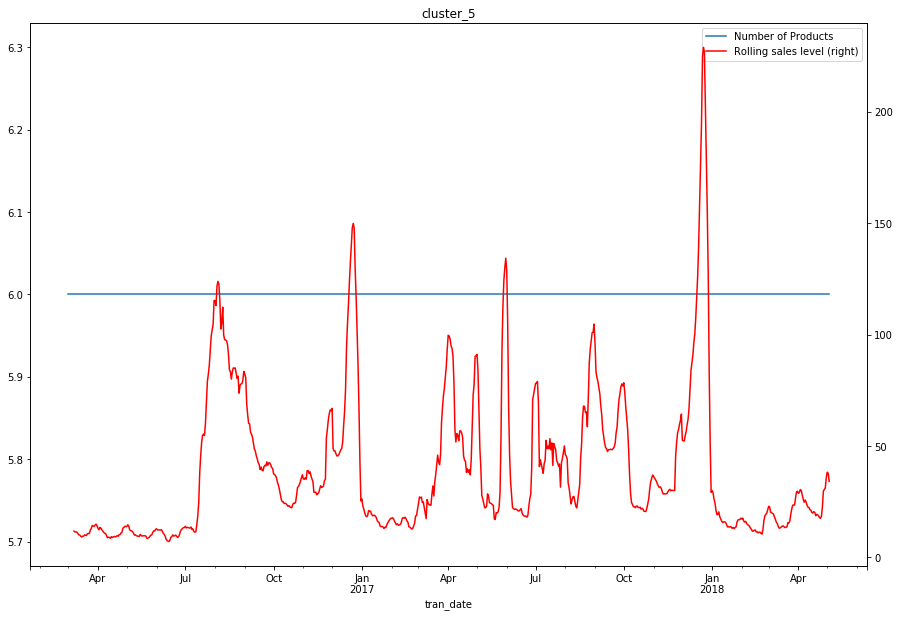

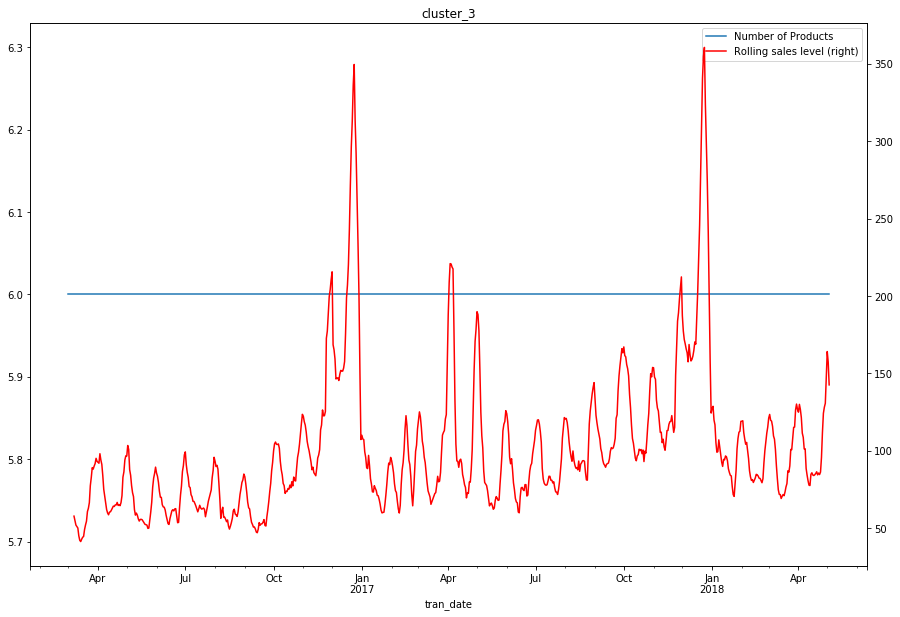

In [55]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'sales', plot_second=True,  period=7)

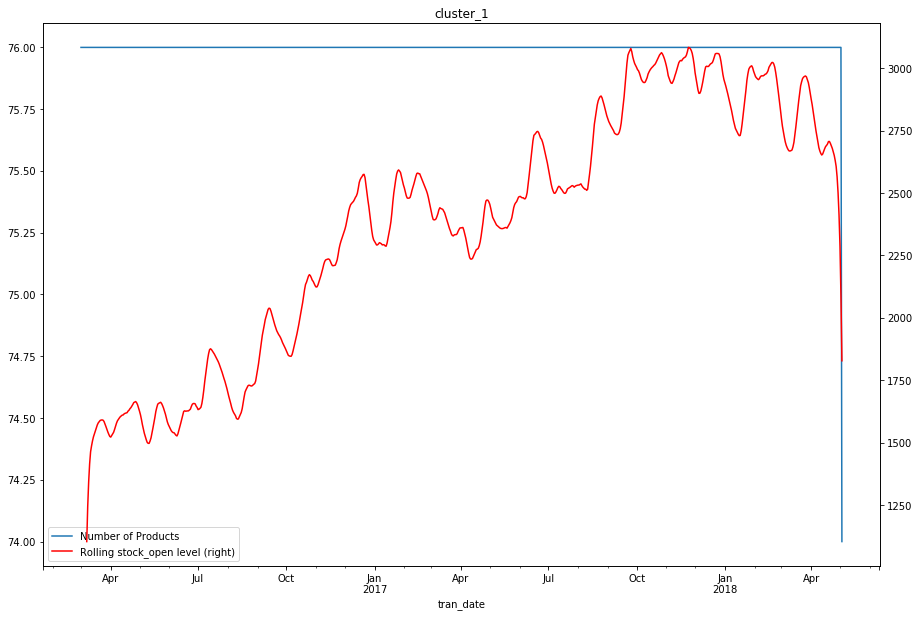

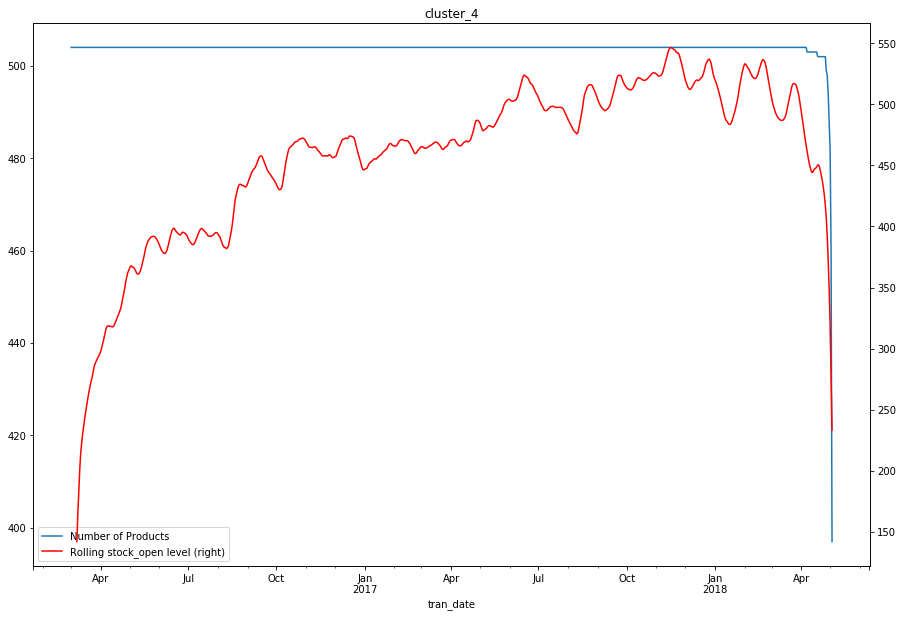

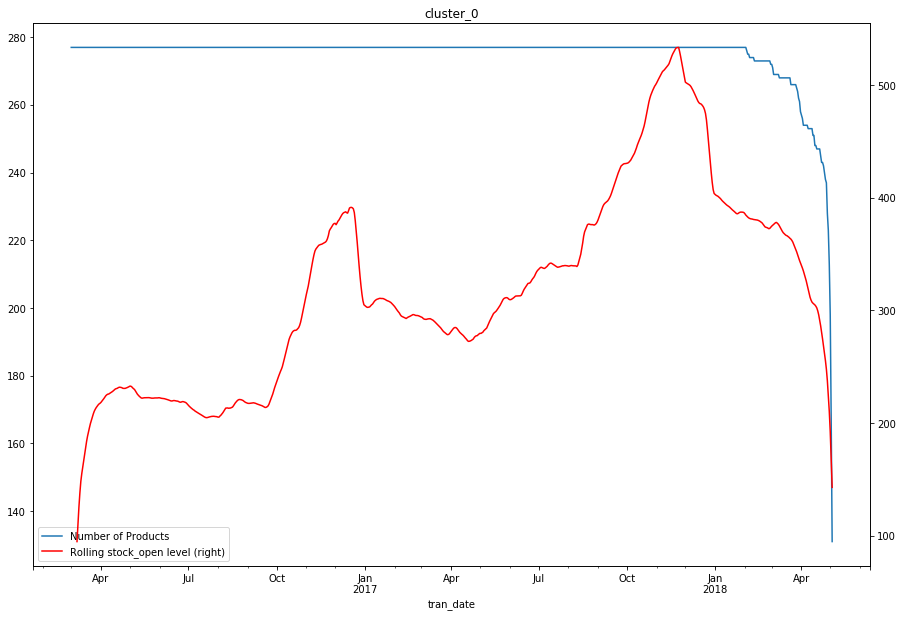

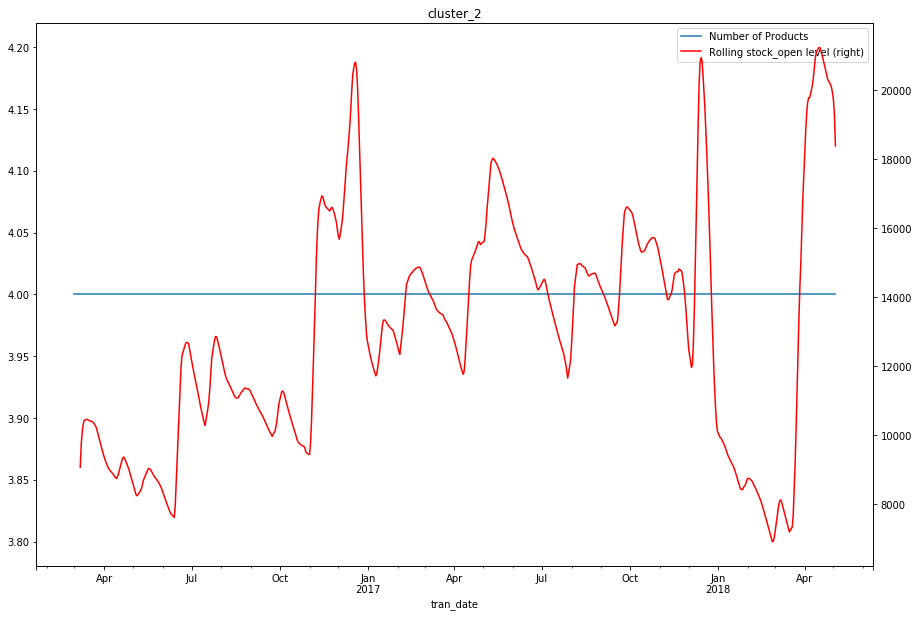

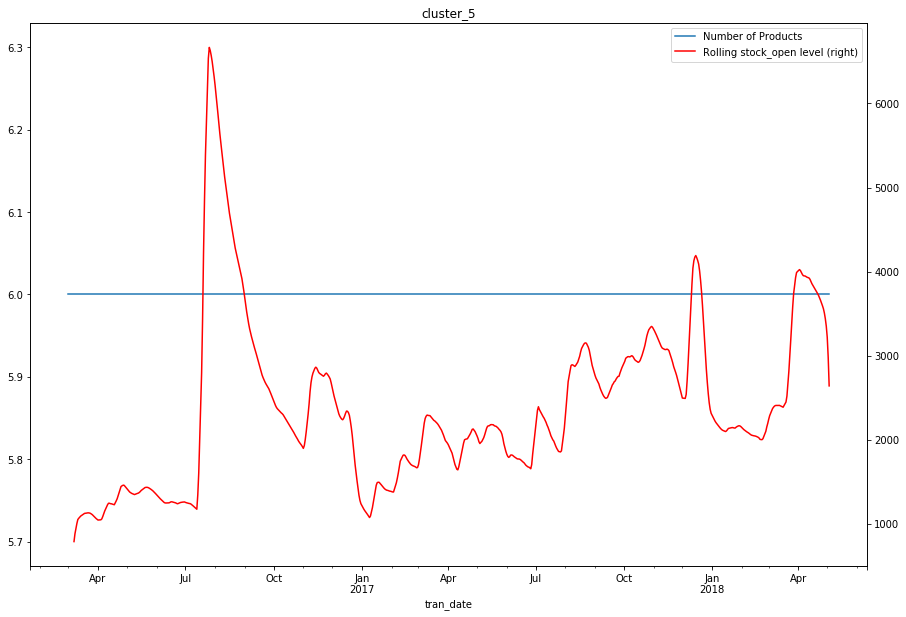

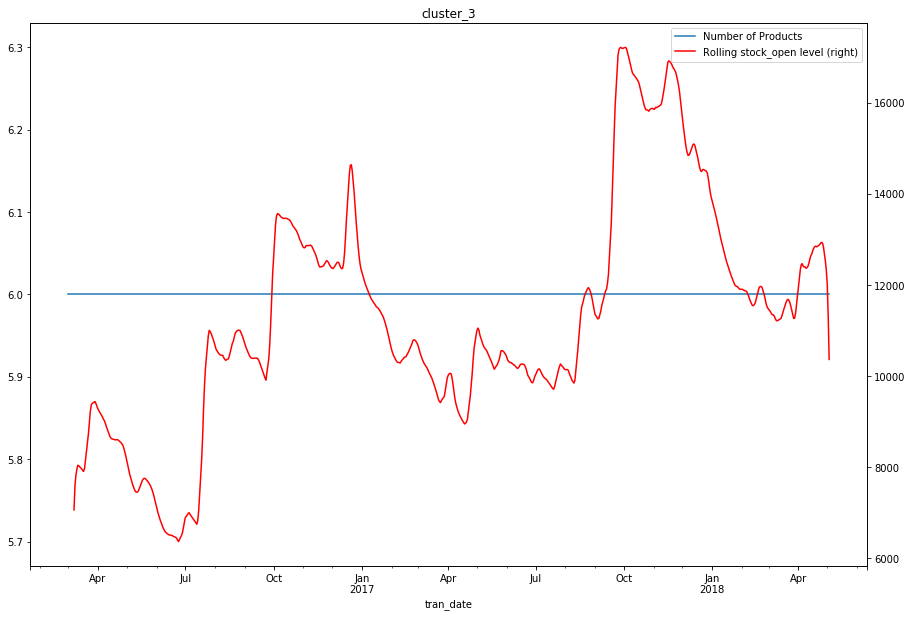

In [29]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'stock_open', plot_second=True,  period=7)

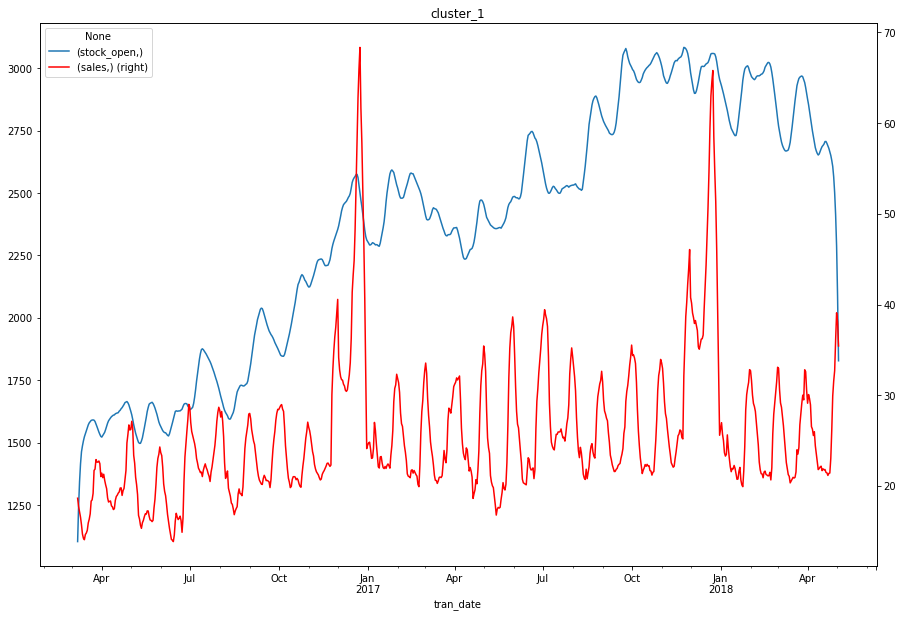

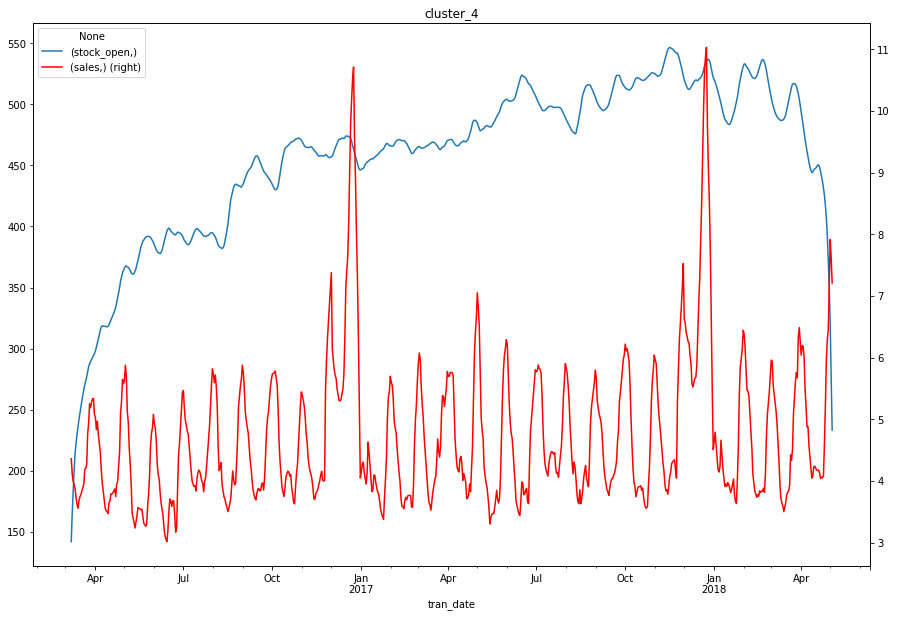

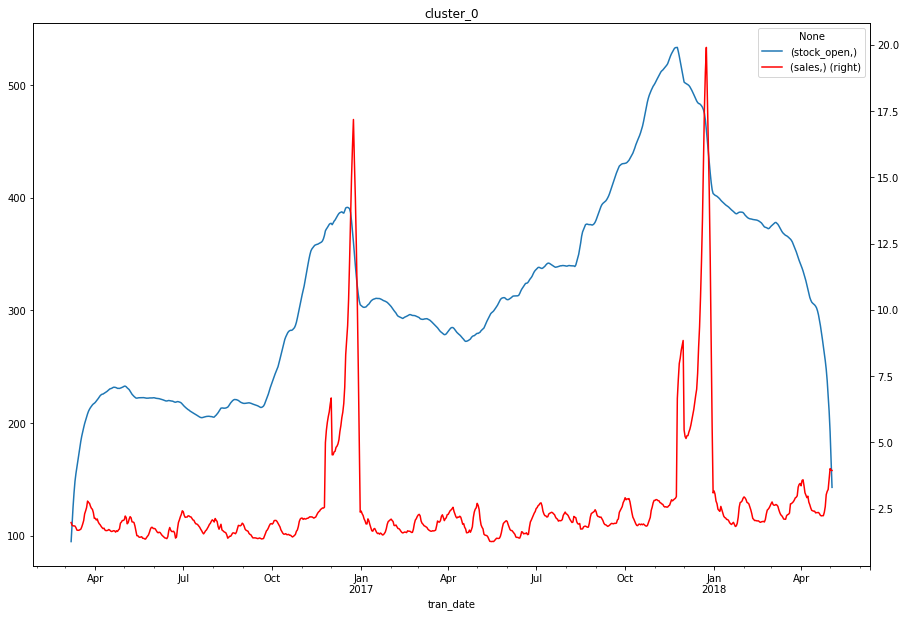

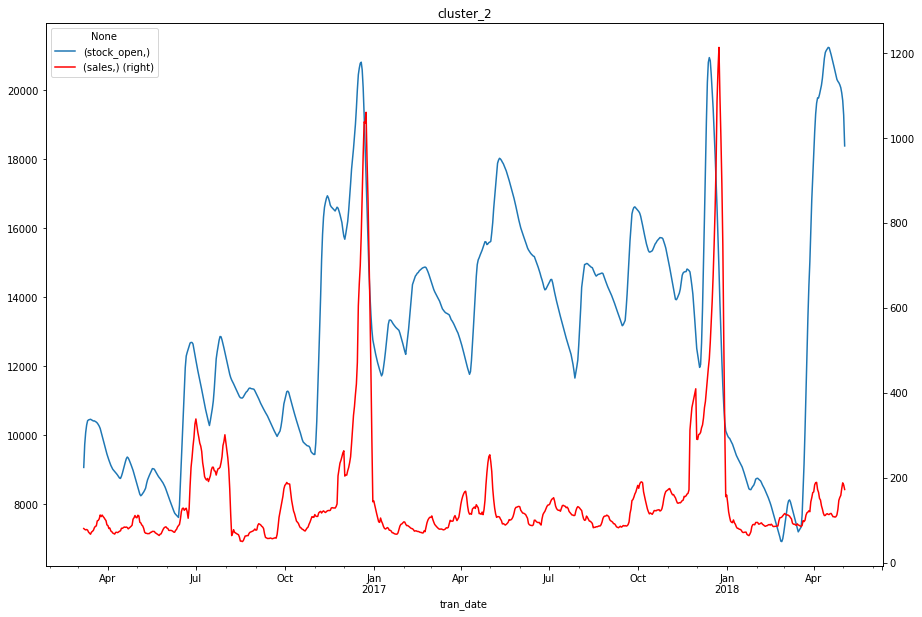

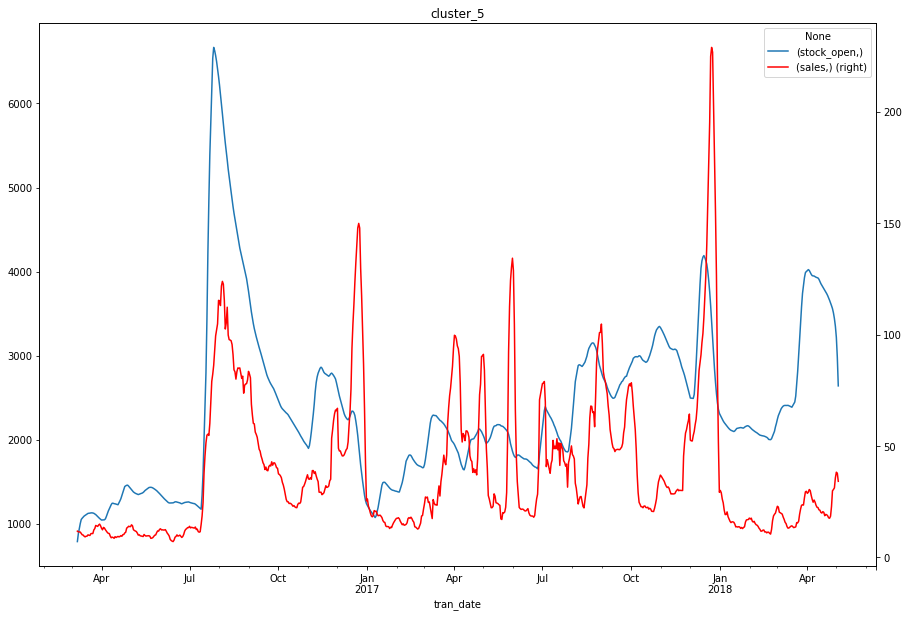

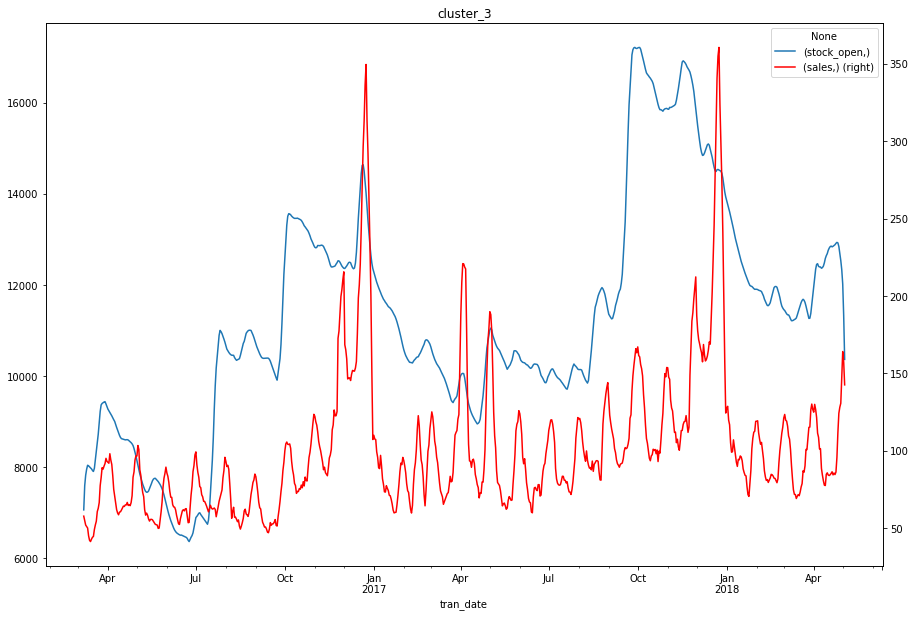

In [30]:
analyze_som.plot_double_rolling_mean(df_dict, ['stock_open', 'sales'], plot_second=True,  period=7)

In [31]:
df_dict['cluster_0'].groupby('tran_date').count()

sku_key  cluster  sales  selling_price  avg_discount  stock_open  \
tran_date                                                                      
2016-03-01      277      277    277            277           277         277   
2016-03-02      277      277    277            277           277         277   
2016-03-03      277      277    277            277           277         277   
2016-03-04      277      277    277            277           277         277   
2016-03-05      277      277    277            277           277         277   
2016-03-06      277      277    277            277           277         277   
2016-03-07      277      277    277            277           277         277   
2016-03-08      277      277    277            277           277         277   
2016-03-09      277      277    277            277           277         277   
2016-03-10      277      277    277            277           277         277   
2016-03-11      277      277    277            277           277         277   
2016-03-12      277      277    277            277           277         277   
2016-03-13      277      277    277            277           277         277   
2016-03-14      277      277    277            277           277         277   
2016-03-15      277      277    277            277           277         277   
2016-03-16      277      277    277            277           277         277   
2016-03-17      277      277    277            277           277         277   
2016-03-18      277      277    277            277           277         277   
2016-03-19      277      277    277            277           277         277   
2016-03-20      277      277    277            277           277         277   
2016-03-21      277      277    277            277           277         277   
2016-03-22      277      277    277            277           277         277   
2016-03-23      277      277    277            277           277         277   
2016-03-24      277      277    277            277           277         277   
2016-03-25      277      277    277            277           277         277   
2016-03-26      277      277    277            277           277         277   
2016-03-27      277      277    277            277           277         277   
2016-03-28      277      277    277            277           277         277   
2016-03-29      277      277    277            277           277         277   
2016-03-30      277      277    277            277           277         277   
...             ...      ...    ...            ...           ...         ...   
2018-04-04      254      254    254            254           254         254   
2018-04-05      254      254    254            254           254         254   
2018-04-06      254      254    254            254           254         254   
2018-04-07      254      254    254            254           254         254   
2018-04-08      253      253    253            253           253         253   
2018-04-09      253      253    253            253           253         253   
2018-04-10      253      253    253            253           253         253   
2018-04-11      253      253    253            253           253         253   
2018-04-12      253      253    253            253           253         253   
2018-04-13      251      251    251            251           251         251   
2018-04-14      251      251    251            251           251         251   
2018-04-15      248      248    248            248           248         248   
2018-04-16      248      248    248            248           248         248   
2018-04-17      247      247    247            247           247         247   
2018-04-18      247      247    247            247           247         247   
2018-04-19      247      247    247            247           247         247   
2018-04-20      247      247    247            247           247         247   
2018-04-21  

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_1, there are 76 skus and 1551438 sales.


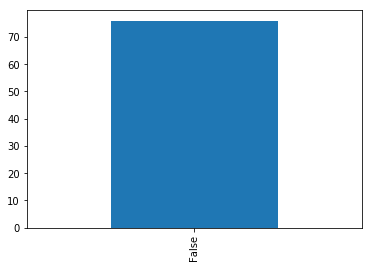

cluster_4, there are 504 skus and 1891330 sales.


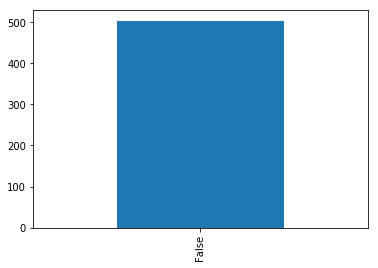

cluster_0, there are 277 skus and 580110 sales.


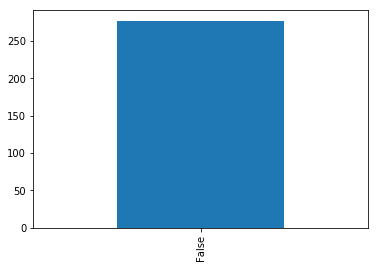

cluster_2, there are 4 skus and 480468 sales.


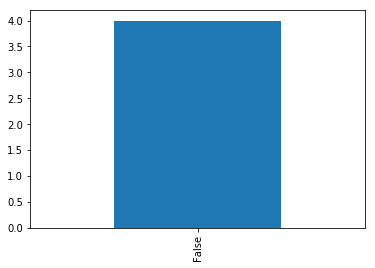

cluster_5, there are 6 skus and 188824 sales.


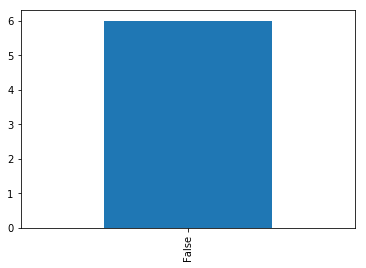

cluster_3, there are 6 skus and 483353 sales.


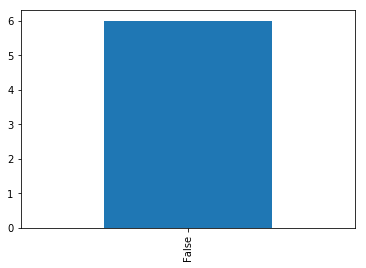

In [34]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

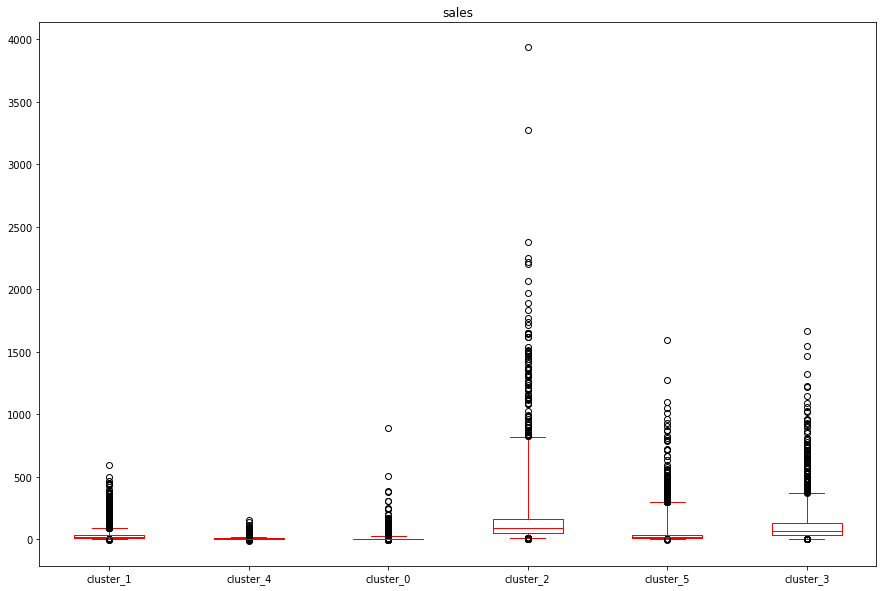

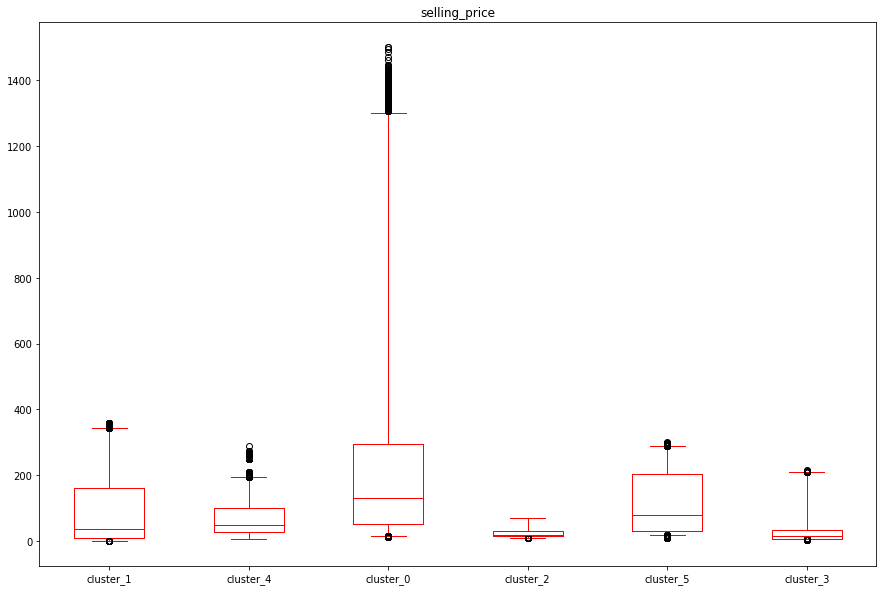

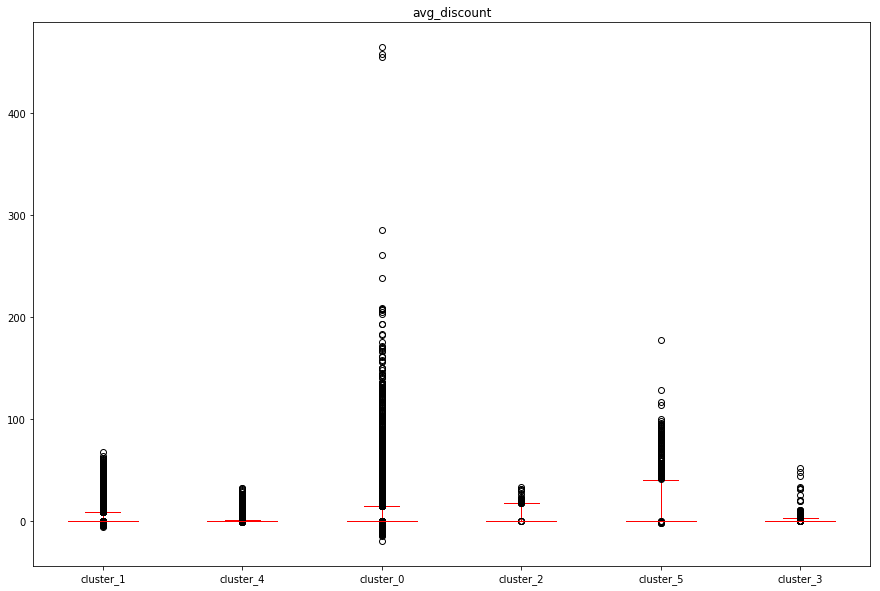

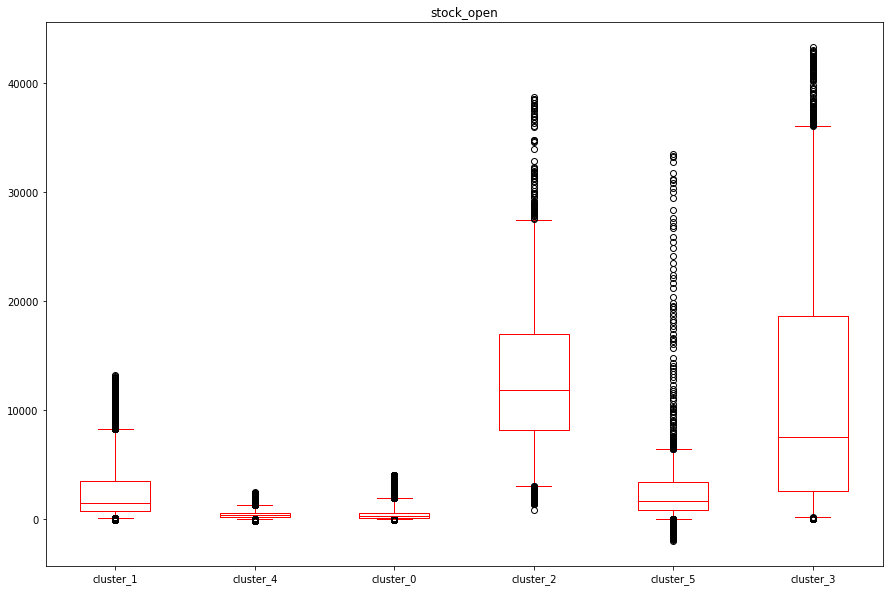

In [33]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Have a look at the number of returns per cluster and relative percentage

cluster_1 had 60342 sale events
cluster_4 had 399937 sale events
cluster_0 had 218278 sale events
cluster_2 had 3176 sale events
cluster_5 had 4764 sale events
cluster_3 had 4764 sale events


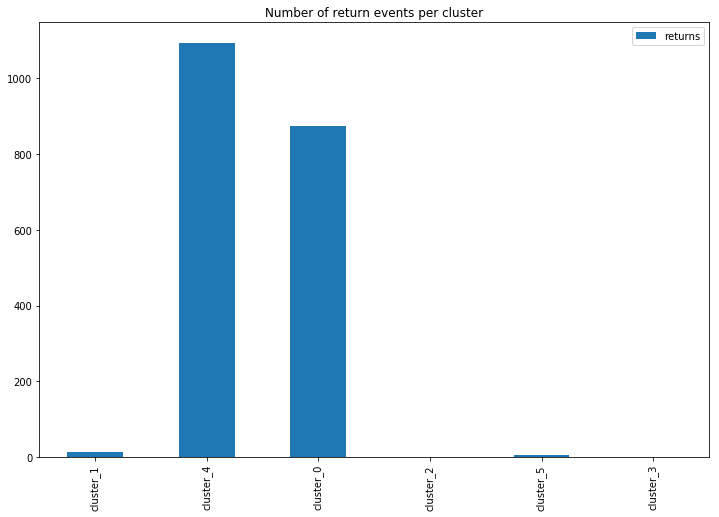

In [32]:
listy = {}
for a, i in df_dict.items():
    print('{} had {} sale events'.format(a, len(i['sales'])))
    x = i[i['sales'] < 0]['sales'].count()
    listy[a] = x
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Number of return events per cluster')
plt.show()

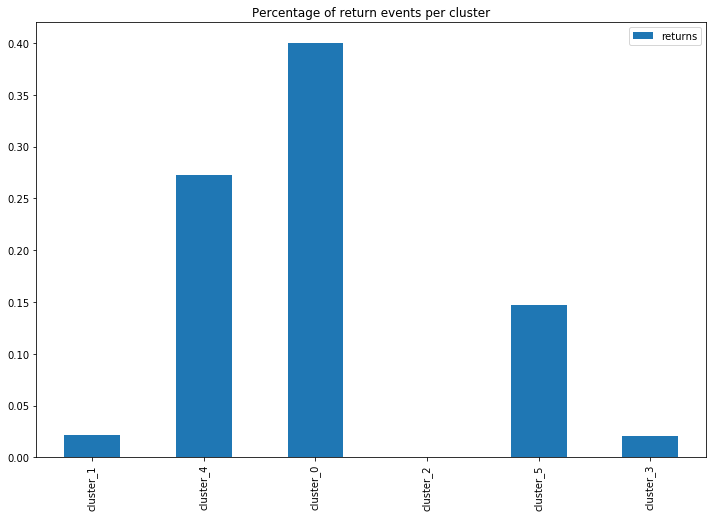

In [35]:
listy = {}
for a, i in df_dict.items():
    x = i[i['sales'] < 0]['sales'].count()/i['sales'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of return events per cluster')
plt.show()

Look at the stock shortages

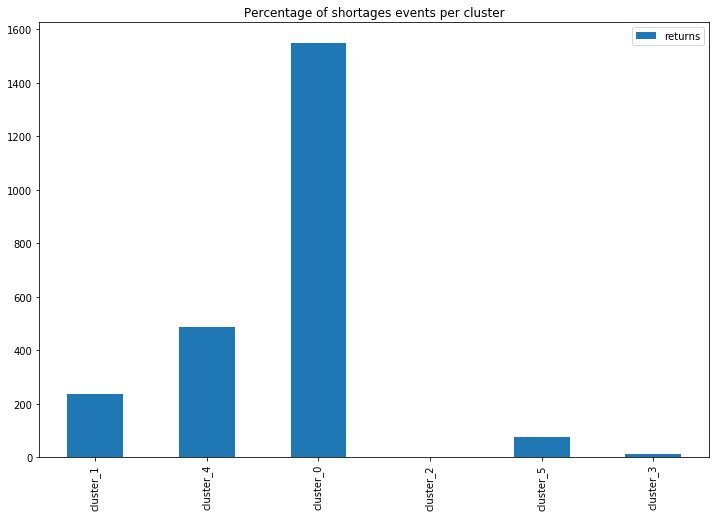

In [36]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

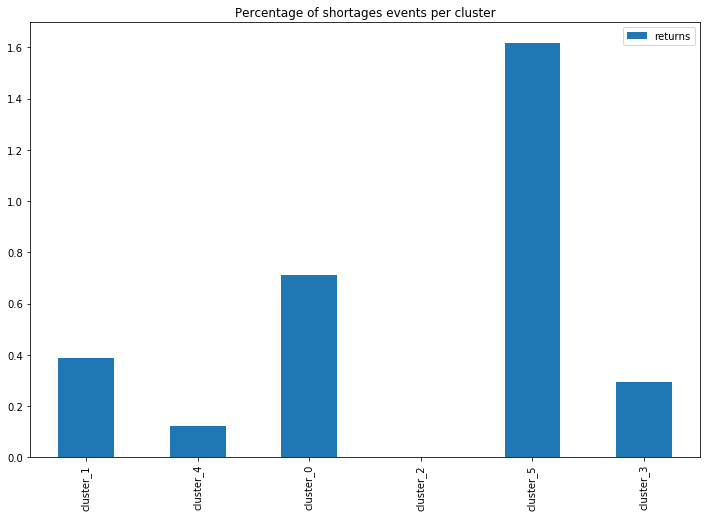

In [37]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()/i['stock_open'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

Categorical variables per cluster



 sku_department


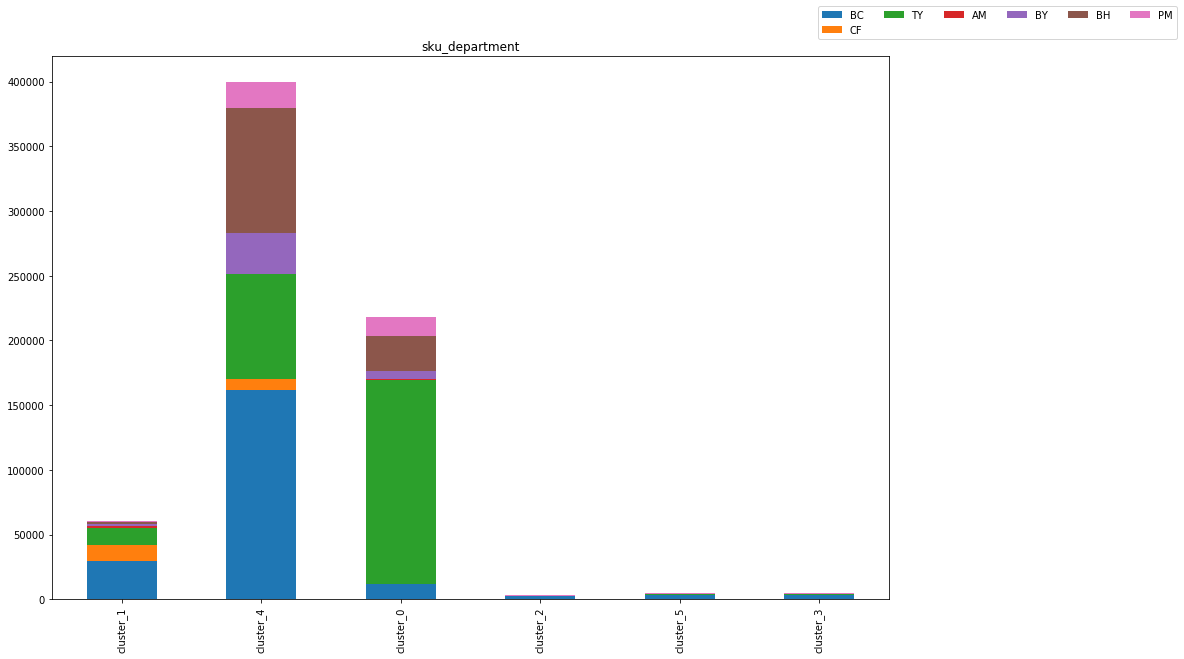



 sku_subdepartment


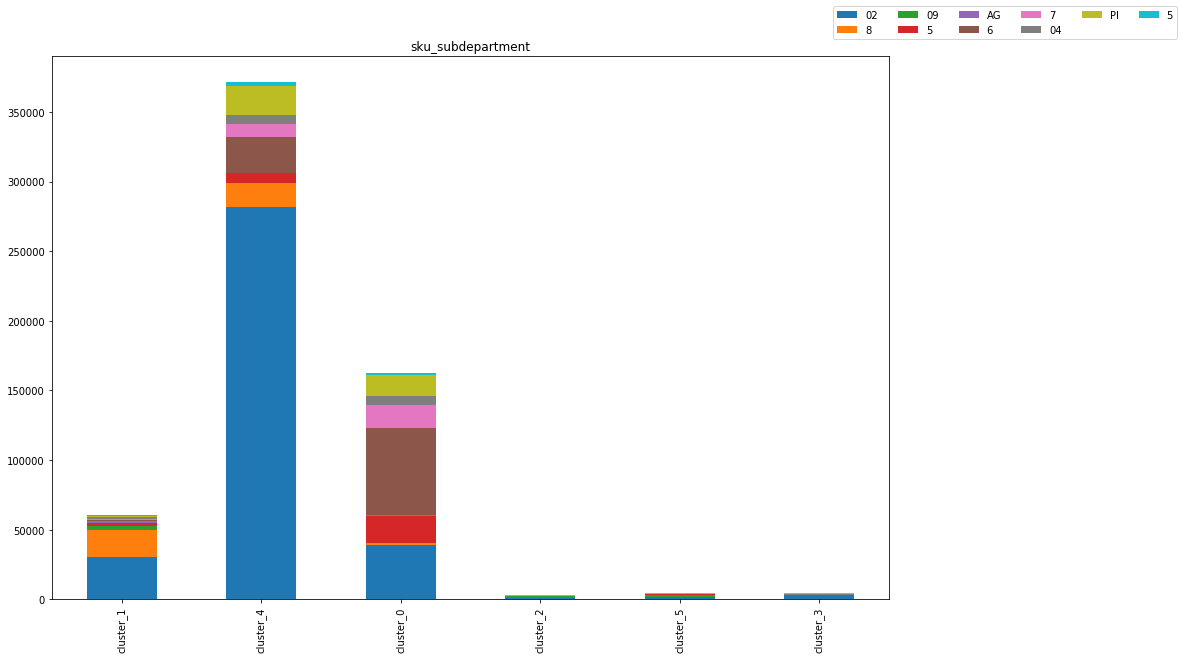



 sku_category


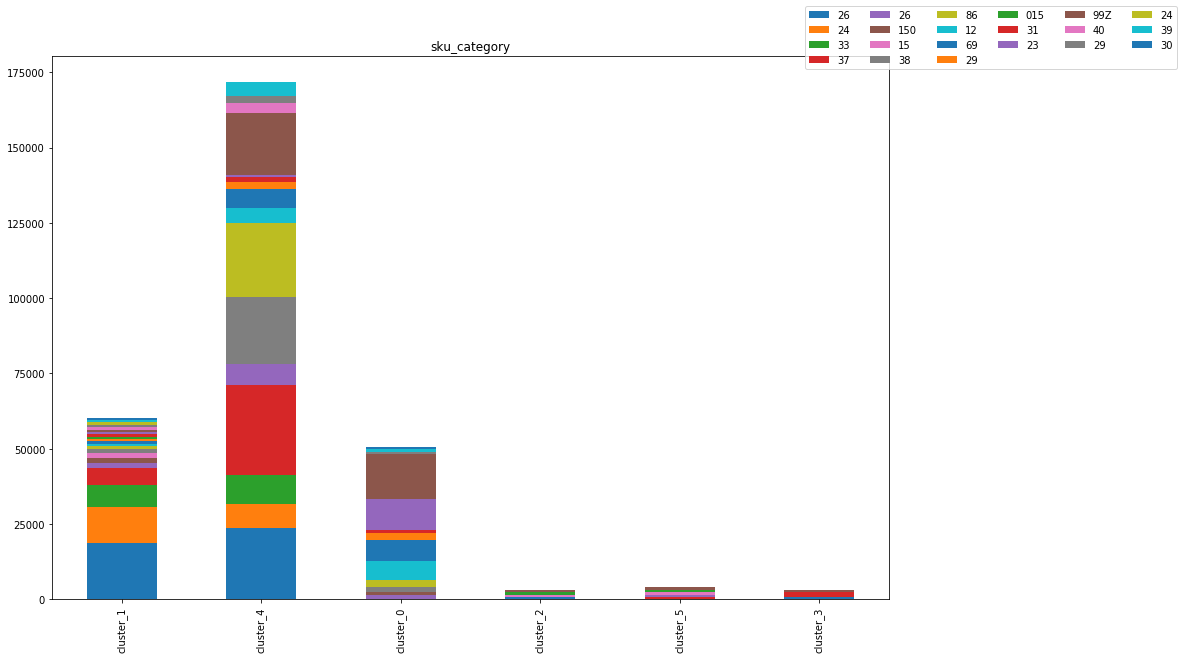



 sku_subcategory


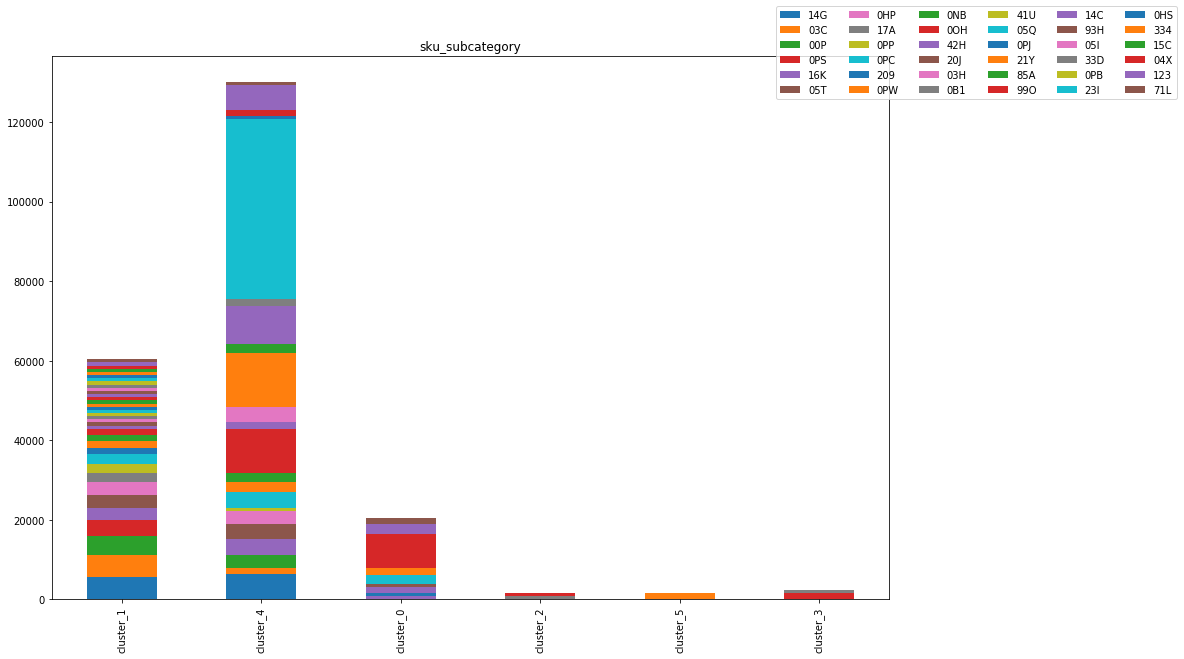



 sku_label


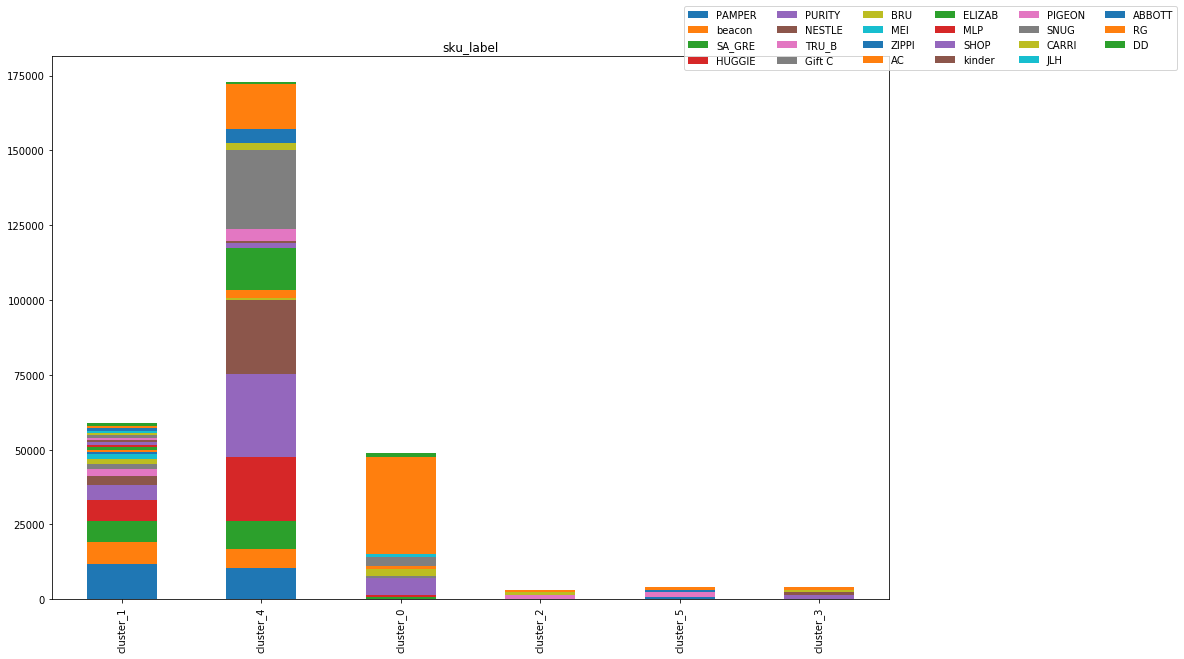

In [38]:
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

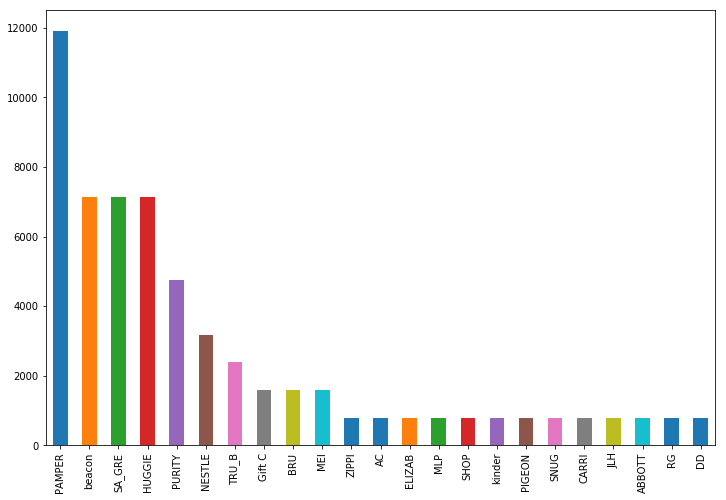

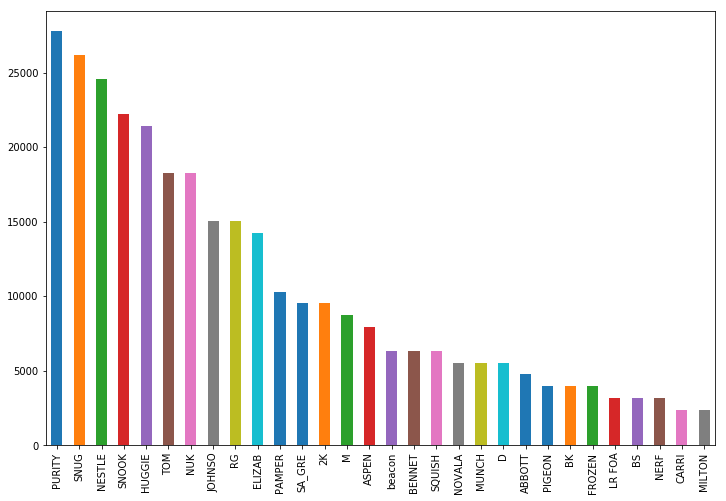

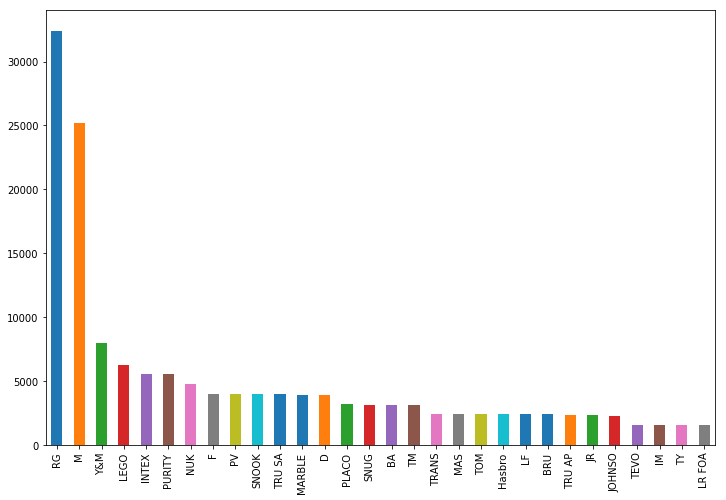

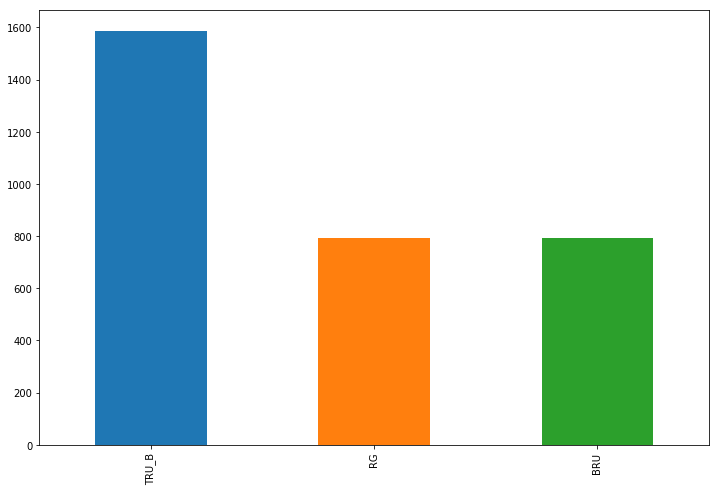

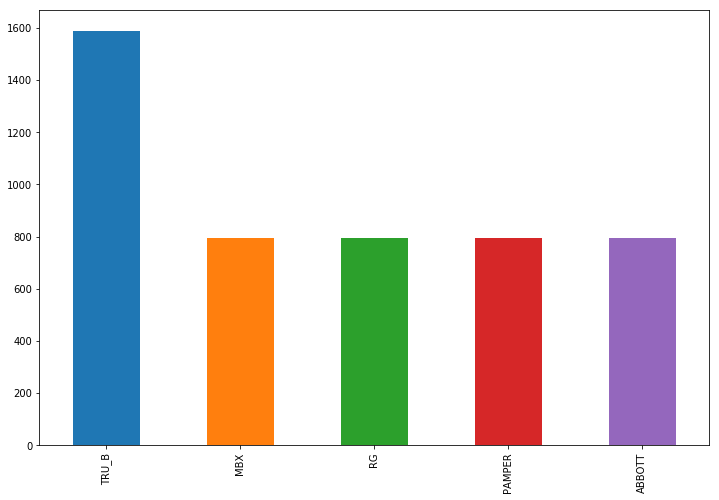

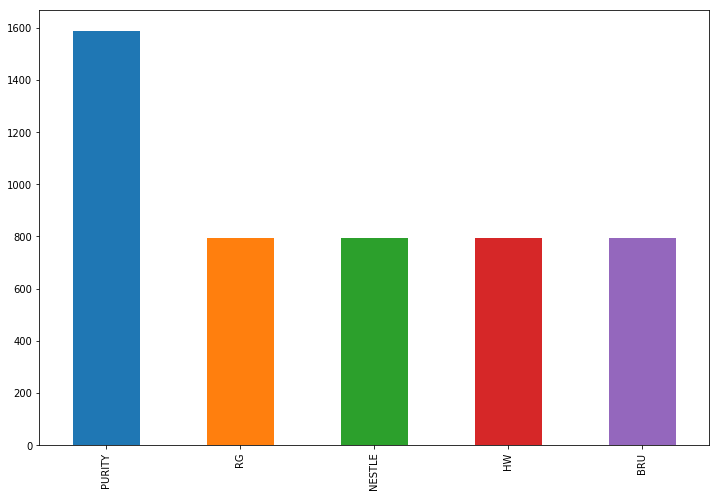

In [40]:
for i in df_dict.values():
    f = plt.figure(figsize=(12,8))
    i['sku_label'].value_counts()[:30].plot(kind='bar')
    plt.show()

Some messy inferential stats:

In [39]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq        df             F  PR(>F)
cluster   1.167605e+08       5.0  13585.319427     0.0
Residual  3.329965e+08  193724.0           NaN     NaN 

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1    group2   meandiff   lower     upper   reject
--------------------------------------------------------
cluster_0 cluster_1  21.6465   20.9663   22.3267   True 
cluster_0 cluster_2  147.2166  145.0657  149.3675  True 
cluster_0 cluster_3  97.3952   95.6172   99.1733   True 
cluster_0 cluster_4   1.139     0.4588    1.8192   True 
cluster_0 cluster_5  35.5713   33.7933   37.3494   True 
cluster_1 cluster_2  125.5701  123.4192  127.721   True 
cluster_1 cluster_3  75.7487   73.9707   77.5268   True 
cluster_1 cluster_4  -20.5075  -21.1877  -19.8273  True 
cluster_1 cluster_5  13.9249   12.1468   15.7029   True 
cluster_2 cluster_3  -49.8214  -52.5279  -47.1149  True 
cluster_2 cluster_4 -146.0776 -148.2285 -143.9267  True 
cluster_2 cluster_5 -111.

Now moving to cumulative sales per cluster

In [48]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

sku_key  sales          0          1  sales_log  cluster
0       34    794  21.870888  18.115337   2.899821        4
1      100   9186  25.310310  16.459806   3.963126        4
2      101     27  17.781155  13.033880   1.431364        0
3      182  36164  24.964161  22.834213   4.558276        1
4      325   3625  24.662046  15.648250   3.559308        0

cluster 4
504


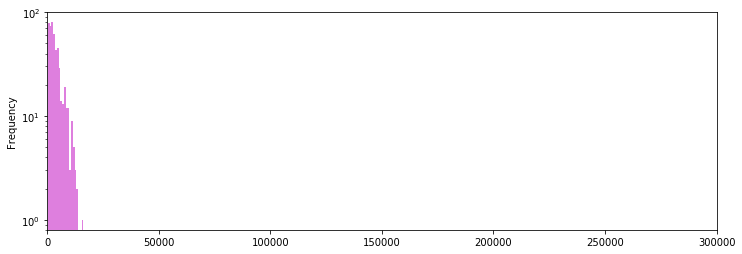

cluster 0
277


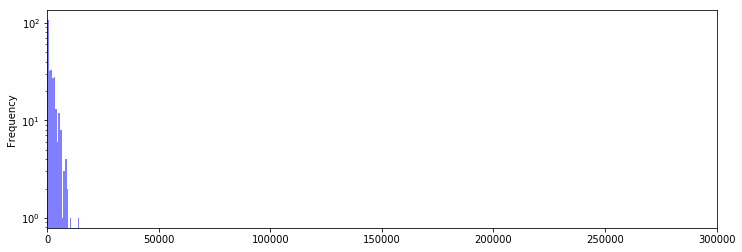

cluster 1
76


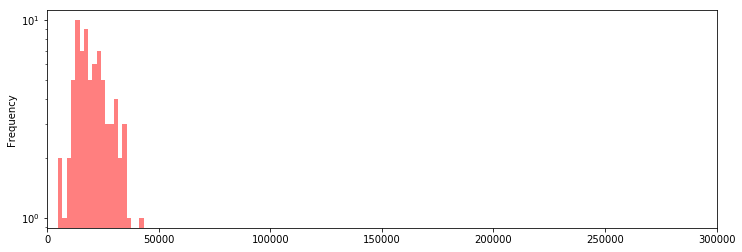

cluster 5
6


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


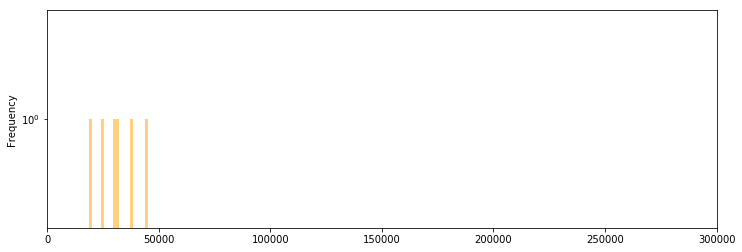

cluster 3
6


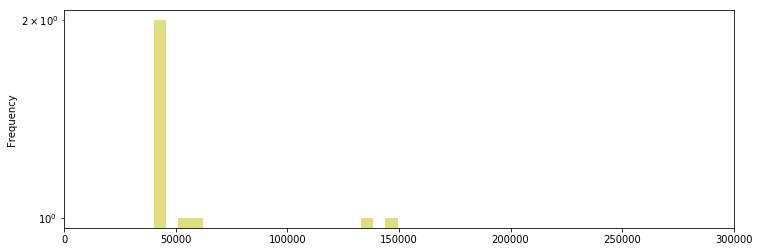

cluster 2
4


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


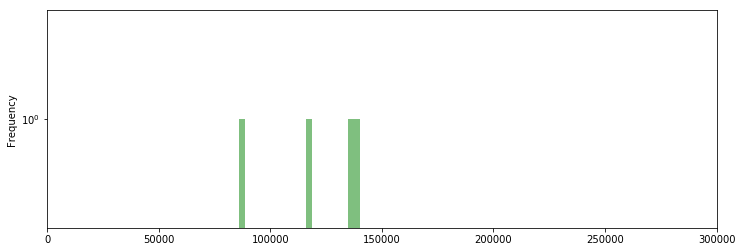

In [49]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 300000)
    plt.show()

In [50]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


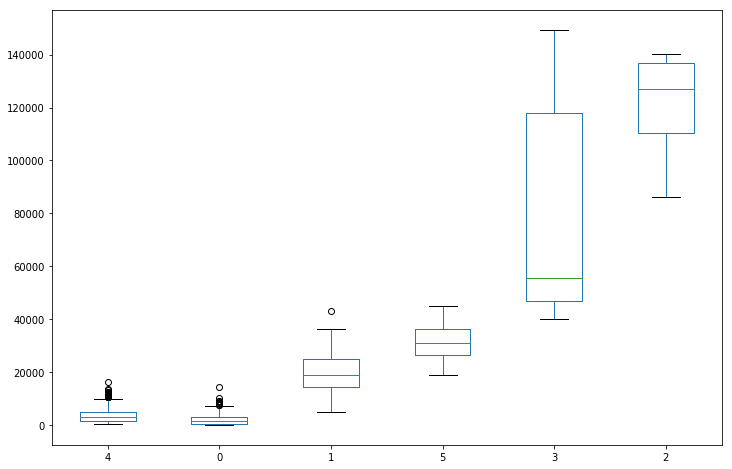

In [51]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [52]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

cluster   value
0        4   794.0
1        4  9186.0
5        4  1935.0
6        4  1155.0
7        4  2200.0

In [53]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq     df         F    PR(>F)
cluster   2.239289e+07    1.0  0.143037  0.705372
Residual  1.363577e+11  871.0       NaN       NaN


In [54]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper    reject
----------------------------------------------------------
  0      1     18319.398    16353.9287   20284.8672  True 
  0      2    118022.7401  110378.9481  125666.5321  True 
  0      3     78464.5734   72201.2723   84727.8745  True 
  0      4      1658.379     523.1174    2793.6406   True 
  0      5     29376.4067   23113.1057   35639.7078  True 
  1      2     99703.3421   91916.9946  107489.6896  True 
  1      3     60145.1754   53708.6708   66581.6801  True 
  1      4     -16661.019  -18528.7637  -14793.2743  True 
  1      5     11057.0088   4620.5041    17493.5134  True 
  2      3    -39558.1667  -49355.7724  -29760.5609  True 
  2      4    -116364.3611 -123983.6102 -108745.112  True 
  2      5    -88646.3333  -98443.9391  -78848.7276  True 
  3      4    -76806.1944  -83039.5195  -70572.8694  True 
  3      5    -49088.1667  -57851.4117  -40324.9217  Tru